<a href="https://colab.research.google.com/github/jimmmmmmmyzzy/Data_Ninja_DigiChemons/blob/main/DA_Assignment_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project


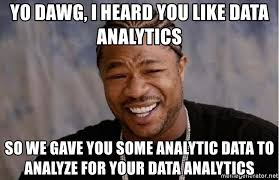  


- For your final project, you will be asked to analyse data from the following paper: [The Photoswitch Dataset: A Molecular Machine Learning Benchmark for the Advancement of Synthetic Chemistry](https://arxiv.org/abs/2008.03226). 

- In this data, you will find a variety of measurements done for a total of 405 molecules. However, the original paper's data only contains [SMILES](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system) representations of the molecules, and in order to do anything useful with this we need to "featurise" them, which means to turn the character strings describing molecules into quantitative data that can then be used by the models to be learnt and fit on. Since this step can sometimes be a little involved (much research in cheminformatics is dedicated to this field!), I have prepared this for you. You will find the data featurised in three distinct ways:

    1. Using Morgan fingerprints as implemented in [RDKit](https://www.rdkit.org/docs/GettingStartedInPython.html#morgan-fingerprints-circular-fingerprints). This is a popular method to turn molecules of any shape into fixed sized vectors of binary data. The authors of the paper also use this method. 
    2. Using all molecular descriptors available in RDKit. I'm not sure if a comprehensive list of the descriptors exists, but they can all be looked up in the rdkit [documentation](https://www.rdkit.org/docs/source/rdkit.Chem.html). This is partially also used in the paper.
    3. Using the [mordred package](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-018-0258-y), containing some 1826 descriptors, 1427 of which returned non-erroneous features for the molecules in the photoswitch dataset. For a complete list of all descriptors, click [here](https://mordred-descriptor.github.io/documentation/master/descriptors.html). This is not in the paper and may offer additional descriptors that could be important.


- In the Github repository for this course, you will find a folder entitled `final_project_data`, which contains the following: 
    * `Featurisation.ipynb` (My finished notebook with all the commented (!!!) code necessary to obtain the data below, in case you want to change parameters, in particular for fingerprints. Since this may be a little advanced, this is absolutely not mandatory!)
    * `photoswitches.csv` (this is the original data, SMILES + outcome measurements, i.e. transition wavelengths)
    * `morgan_fingerprints.csv` (SMILES + Morgan fingerprints)
    * `rdkit_descriptors.csv` (SMILES + rdkit descriptors)
    * `mordred_descriptors.csv` (SMILES + mordred descriptors)
    * `molecule_images` (A folder containing Chemdraw style pictures of all 405 molecules)


- Some ideas to get you started: 
    * Compare & contrast methods of featurisation (fingerprints have no real-life equivalents as opposed to descriptors etc)
    * Attempt to predict the other measurements (e.g. Extinction coefficient)
    * Supervised learning:
        * Improve model (particularly RFs) by pruning parameters 
        * Get most important predictors from RF, does that say anything about chemistry?
        * Compute scores from paper (RMSE, MAE, R^2) and compare, maybe improved? 
        * Could even try neural networks? 
    * Unsupervised learning:
        * Clustering 405 molecules should be somewhat of a tangible, tractable task, what groups of molecules are you seeing?
        * Paper does have advanced methods of dimensionality reduction, but maybe even PCA etc. can show stuff, too. Should be interesting to see if featurisation matters!


### Best of luck!


# Part 1 - Some housekeeping stuff

In [1]:
pip install rdkit-pypi

     |████████████████████████████████| 20.6 MB 1.3 MB/s 


In [3]:
pip install mordred

     |████████████████████████████████| 128 kB 9.6 MB/s 
  Created wheel for mordred: filename=mordred-1.2.0-py3-none-any.whl size=176723 sha256=973bb9aad0fc80f98de1a307d2303390d722efc2736dc39dd7da4b86f3ba4e1e
  Stored in directory: /root/.cache/pip/wheels/02/c0/2e/e7e3d63b431777712ebc128bc4deb9ac5cb19afc7c1ea341ec
Successfully built mordred


In [4]:
#we first import some useful libraries
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from rdkit import Chem # rdkit contains a number of molecular descriptors
from rdkit.Chem.rdmolops import GetAdjacencyMatrix
from rdkit.Chem import AllChem, Descriptors, MolFromSmiles
from rdkit.Chem.Crippen import MolLogP,MolMR
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_swiss_roll, load_iris, fetch_openml, make_blobs, load_wine, make_moons, fetch_olivetti_faces
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, silhouette_score, silhouette_samples
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE, Isomap, MDS, LocallyLinearEmbedding
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
import tensorflow as tf
import seaborn as sns

In [81]:
# Convert a single SMILES to RDKIT molecule format
def SMILES2MOL(mole):
    return Chem.MolFromSmiles(mole)
# Convert an array/vector of SMILES data to RDKIT mole format
def SMILES2MOLES(moles):
    vectSMILES2MOL=np.vectorize(SMILES2MOL)
    return vectSMILES2MOL(moles)

In [6]:
# Import main data and get list of SMILES
photoswitches_raw = pd.read_csv('https://raw.githubusercontent.com/jimmmmmmmyzzy/Data_Ninja_DigiChemons/main/photoswitches.csv')  # Load the photoswitch dataset using pandas
smiles_list = photoswitches_raw['SMILES'].to_list()

In [7]:
# Let's have a look at our dataset
photoswitches_raw

Unnamed: 0  ... BHLYP/6-31G* DFT Z isomer n-pi* wavelength in nm
0             0  ...                                              NaN
1             1  ...                                              NaN
2             2  ...                                              NaN
3             3  ...                                              NaN
4             4  ...                                              NaN
..          ...  ...                                              ...
400         400  ...                                              NaN
401         401  ...                                              NaN
402         402  ...                                              NaN
403         403  ...                                              NaN
404         404  ...                                              NaN

[405 rows x 34 columns]

In [8]:
# Don't you feel irritated seeing the same column twice? So, let's delete the second column!
photoswitches = photoswitches_raw.drop(['Unnamed: 0'],axis=1)
photoswitches

SMILES  ...  BHLYP/6-31G* DFT Z isomer n-pi* wavelength in nm
0                         C[N]1N=NC(=N1)N=NC2=CC=CC=C2  ...                                               NaN
1                         C[N]1C=NC(=N1)N=NC2=CC=CC=C2  ...                                               NaN
2                         C[N]1C=CC(=N1)N=NC2=CC=CC=C2  ...                                               NaN
3                      C[N]1C=C(C)C(=N1)N=NC2=CC=CC=C2  ...                                               NaN
4                         C[N]1C=C(C=N1)N=NC2=CC=CC=C2  ...                                               NaN
..                                                 ...  ...                                               ...
400  OC%38=C%39N=CC=CC%39=C(/N=N/C%40=NC%41=CC(C)=C...  ...                                               NaN
401  OC%42=C%43N=CC=CC%43=C(/N=N/C%44=NC%45=CC=CC=C...  ...                                               NaN
402  N#CC1C(SC(/N=N/C2=NC(C=CC([N+]([O-])=O)=C3)=C3...  ...                                               NaN
403  N#Cc5c(c6ccc(Cl)cc6)c(/N=N/C7=NC(C=CC([N+]([O-...  ...                                               NaN
404  N#CC9C(SC(/N=N/C%10=NC(C=CC([N+]([O-])=O)=C%11...  ...                                               NaN

[405 rows x 33 columns]

In [9]:
#Identify the missing values in each attribute 
# Also we can have a quick glimpse of each descriptor used in the papaer 
photoswitches.isnull().sum()

SMILES                                                      0
rate of thermal isomerisation from Z-E in s-1             330
Solvent used for thermal isomerisation rates              353
Z PhotoStationaryState                                    329
E PhotoStationaryState                                    331
E isomer pi-pi* wavelength in nm                           13
Extinction                                                372
E isomer n-pi* wavelength in nm                           264
Extinction coefficient in M-1 cm-1                        379
Z isomer pi-pi* wavelength in nm                          312
Extinction.1                                              393
Z isomer n-pi* wavelength in nm                           282
Extinction coefficient in M-1 cm-1.1                      382
Wiberg index                                              390
E-Z irradiation wavelength in nm                          341
Z-E irradiation wavelength                                341
Irradiat

In [10]:
photoswitches['SMILES']

0                           C[N]1N=NC(=N1)N=NC2=CC=CC=C2
1                           C[N]1C=NC(=N1)N=NC2=CC=CC=C2
2                           C[N]1C=CC(=N1)N=NC2=CC=CC=C2
3                        C[N]1C=C(C)C(=N1)N=NC2=CC=CC=C2
4                           C[N]1C=C(C=N1)N=NC2=CC=CC=C2
                             ...                        
400    OC%38=C%39N=CC=CC%39=C(/N=N/C%40=NC%41=CC(C)=C...
401    OC%42=C%43N=CC=CC%43=C(/N=N/C%44=NC%45=CC=CC=C...
402    N#CC1C(SC(/N=N/C2=NC(C=CC([N+]([O-])=O)=C3)=C3...
403    N#Cc5c(c6ccc(Cl)cc6)c(/N=N/C7=NC(C=CC([N+]([O-...
404    N#CC9C(SC(/N=N/C%10=NC(C=CC([N+]([O-])=O)=C%11...
Name: SMILES, Length: 405, dtype: object

In [11]:
#Identify which columns are numerical and categorical (this can help us with the decision of the learning algorithms later):
photoswitches.dtypes

SMILES                                                     object
rate of thermal isomerisation from Z-E in s-1             float64
Solvent used for thermal isomerisation rates               object
Z PhotoStationaryState                                    float64
E PhotoStationaryState                                    float64
E isomer pi-pi* wavelength in nm                          float64
Extinction                                                float64
E isomer n-pi* wavelength in nm                           float64
Extinction coefficient in M-1 cm-1                        float64
Z isomer pi-pi* wavelength in nm                          float64
Extinction.1                                              float64
Z isomer n-pi* wavelength in nm                           float64
Extinction coefficient in M-1 cm-1.1                      float64
Wiberg index                                              float64
E-Z irradiation wavelength in nm                           object
Z-E irradi

In [12]:
photoswitches_columns = photoswitches.columns[1:].values.tolist()
photoswitches_columns =photoswitches.columns[np.where(photoswitches.dtypes != "object")] 
photoswitches_subset = photoswitches[photoswitches_columns]
photoswitches_subset

rate of thermal isomerisation from Z-E in s-1  ...  BHLYP/6-31G* DFT Z isomer n-pi* wavelength in nm
0                                     2.100000e-07  ...                                               NaN
1                                     3.800000e-07  ...                                               NaN
2                                     1.100000e-07  ...                                               NaN
3                                     1.500000e-06  ...                                               NaN
4                                     7.600000e-09  ...                                               NaN
..                                             ...  ...                                               ...
400                                            NaN  ...                                               NaN
401                                            NaN  ...                                               NaN
402                                            NaN  ...                                               NaN
403                                            NaN  ...                                               NaN
404                                            NaN  ...                                               NaN

[405 rows x 28 columns]

In [13]:
#so, how many molecules do we have?
len(smiles_list)

405

In [14]:
# Initiate a list of rdkit molecules
rdkit_mols = [MolFromSmiles(smiles) for smiles in smiles_list]

In [15]:
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules

smiles = photoswitches.to_numpy()
print(smiles)

[['C[N]1N=NC(=N1)N=NC2=CC=CC=C2' 2.1e-07 'MeCN' ... nan nan nan]
 ['C[N]1C=NC(=N1)N=NC2=CC=CC=C2' 3.8e-07 'MeCN' ... nan nan nan]
 ['C[N]1C=CC(=N1)N=NC2=CC=CC=C2' 1.1e-07 'MeCN' ... nan nan nan]
 ...
 ['N#CC1C(SC(/N=N/C2=NC(C=CC([N+]([O-])=O)=C3)=C3S2)C1C4CCCCC4)N' nan nan
  ... nan nan nan]
 ['N#Cc5c(c6ccc(Cl)cc6)c(/N=N/C7=NC(C=CC([N+]([O-])=O)=C8)=C8S7)sc5N' nan
  nan ... nan nan nan]
 ['N#CC9C(SC(/N=N/C%10=NC(C=CC([N+]([O-])=O)=C%11)=C%11S%10)C9C%12CCC(OC)CC%12)N'
  nan nan ... nan nan nan]]


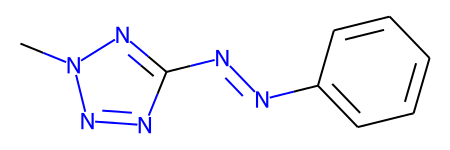

In [16]:
# Draw the structure 
smiles = photoswitches['SMILES'].values
test_mol= Chem.MolFromSmiles(smiles[0])

# Visualize the structure
test_mol

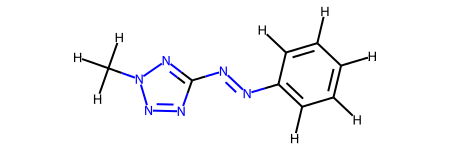

In [17]:
Chem.AddHs(test_mol) #add some Hydrogens hehe

# RDKIT Descriptors

In [23]:
# Write a dictionary of name:function pairs for all descriptors
all_descriptors = {d[0]: d[1] for d in Descriptors.descList}

In [24]:
# Initialise a new pandas df
rdkit_descriptors = pd.DataFrame(data = {"SMILES": np.array((smiles_list)) })
rdkit_descriptors

SMILES
0                         C[N]1N=NC(=N1)N=NC2=CC=CC=C2
1                         C[N]1C=NC(=N1)N=NC2=CC=CC=C2
2                         C[N]1C=CC(=N1)N=NC2=CC=CC=C2
3                      C[N]1C=C(C)C(=N1)N=NC2=CC=CC=C2
4                         C[N]1C=C(C=N1)N=NC2=CC=CC=C2
..                                                 ...
400  OC%38=C%39N=CC=CC%39=C(/N=N/C%40=NC%41=CC(C)=C...
401  OC%42=C%43N=CC=CC%43=C(/N=N/C%44=NC%45=CC=CC=C...
402  N#CC1C(SC(/N=N/C2=NC(C=CC([N+]([O-])=O)=C3)=C3...
403  N#Cc5c(c6ccc(Cl)cc6)c(/N=N/C7=NC(C=CC([N+]([O-...
404  N#CC9C(SC(/N=N/C%10=NC(C=CC([N+]([O-])=O)=C%11...

[405 rows x 1 columns]

In [25]:
# Compute each descriptor (outer loop) for each molecule(inside)
for feature in all_descriptors:
    values = []
    for mol in rdkit_mols:
        values += [all_descriptors[feature](mol)]
    rdkit_descriptors[feature] = values

rdkit_descriptors

SMILES  ...  fr_urea
0                         C[N]1N=NC(=N1)N=NC2=CC=CC=C2  ...        0
1                         C[N]1C=NC(=N1)N=NC2=CC=CC=C2  ...        0
2                         C[N]1C=CC(=N1)N=NC2=CC=CC=C2  ...        0
3                      C[N]1C=C(C)C(=N1)N=NC2=CC=CC=C2  ...        0
4                         C[N]1C=C(C=N1)N=NC2=CC=CC=C2  ...        0
..                                                 ...  ...      ...
400  OC%38=C%39N=CC=CC%39=C(/N=N/C%40=NC%41=CC(C)=C...  ...        0
401  OC%42=C%43N=CC=CC%43=C(/N=N/C%44=NC%45=CC=CC=C...  ...        0
402  N#CC1C(SC(/N=N/C2=NC(C=CC([N+]([O-])=O)=C3)=C3...  ...        0
403  N#Cc5c(c6ccc(Cl)cc6)c(/N=N/C7=NC(C=CC([N+]([O-...  ...        0
404  N#CC9C(SC(/N=N/C%10=NC(C=CC([N+]([O-])=O)=C%11...  ...        0

[405 rows x 209 columns]

In [27]:
from rdkit.Chem import Descriptors

rdkit_columns = rdkit_descriptors.columns[1:].values.tolist()
#new_mordred_descriptors
rdkit_columns =rdkit_descriptors.columns[np.where(rdkit_descriptors.dtypes != "object")] 
rdkit_descriptors_subset = rdkit_descriptors[rdkit_columns].dropna()
rdkit_descriptors_subset

MaxEStateIndex  MinEStateIndex  ...  fr_unbrch_alkane  fr_urea
0          3.936481        0.260512  ...                 0        0
1          3.976481        0.371623  ...                 0        0
2          4.081997        0.621623  ...                 0        0
3          4.181534        0.667920  ...                 0        0
4          4.061481        0.760512  ...                 0        0
..              ...             ...  ...               ...      ...
400        9.883085        0.134711  ...                 0        0
401        9.822888        0.123414  ...                 0        0
402       10.934342       -0.422909  ...                 0        0
403       10.920834       -0.461717  ...                 0        0
404       10.966055       -0.428726  ...                 0        0

[405 rows x 208 columns]

In [28]:
X_sub_rdkit = rdkit_descriptors_subset.to_numpy()


# PCA 
X_sub_rdkit_scaled = StandardScaler().fit_transform(X_sub_rdkit)
X_sub_rdkit_pca = PCA(n_components=0.9).fit_transform(X_sub_rdkit_scaled)
X_sub_rdkit_pca


array([[-8.9093003 , -3.10588195,  0.56114093, ..., -4.25540989,
        -0.29894659,  7.71706384],
       [-8.71066542, -2.72619175,  0.66172801, ..., -0.847986  ,
         0.25919447,  0.05607906],
       [-9.06100018, -0.84669512,  0.57274931, ..., -0.8168959 ,
         0.34051166, -0.18798213],
       ...,
       [15.74420188, -1.42369207,  9.93601204, ...,  1.60866044,
        -0.2164801 , -0.97715675],
       [11.7361142 , -5.88897832,  6.45045005, ..., -1.56866848,
        -2.41979092,  1.46103747],
       [18.53172349, -1.03367089,  9.41670542, ...,  1.92875738,
        -0.54010596, -1.27971929]])

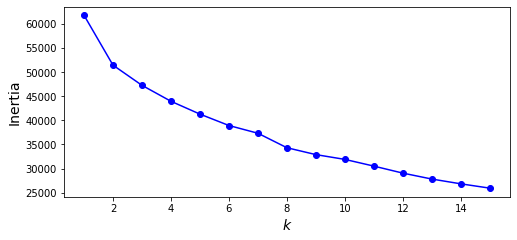

In [29]:
#KMeans and inertias
range_of_ks_1 = range(1,16)
kmeans_per_k_1 = [KMeans(n_clusters=k).fit(X_sub_rdkit_pca) for k in range_of_ks_1]
inertias_1 = [model.inertia_ for model in kmeans_per_k_1]

plt.figure(figsize=(8, 3.5))
plt.plot(range_of_ks_1, inertias_1, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.show()


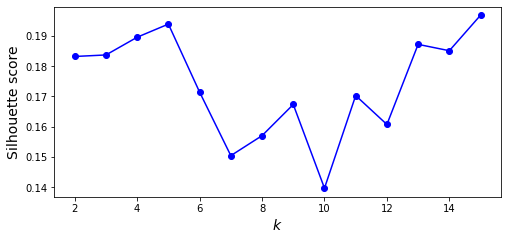

In [30]:
#silhouettes
silhouette_scores_1 = [silhouette_score(X_sub_rdkit_pca, model.labels_)
                        for model in kmeans_per_k_1[1:]]

plt.figure(figsize=(8, 3.5))
plt.plot(range_of_ks_1[1:], silhouette_scores_1, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()


In [31]:
y_sub_rdkit = KMeans(5).fit_predict(X_sub_rdkit_pca)
rndfor_rd = RandomForestClassifier(n_estimators=1000, max_depth = 300)
rndfor_rd.fit(X_sub_rdkit_pca, y_sub_rdkit)
for name, imp in zip(rdkit_descriptors_subset, rndfor_rd.feature_importances_):
    print(name.ljust(20), round(imp,5))

MaxEStateIndex       0.23761
MinEStateIndex       0.14221
MaxAbsEStateIndex    0.13194
MinAbsEStateIndex    0.02431
qed                  0.03127
MolWt                0.04501
HeavyAtomMolWt       0.04688
ExactMolWt           0.01567
NumValenceElectrons  0.01934
NumRadicalElectrons  0.01806
MaxPartialCharge     0.01148
MinPartialCharge     0.02224
MaxAbsPartialCharge  0.02776
MinAbsPartialCharge  0.02442
FpDensityMorgan1     0.01927
FpDensityMorgan2     0.02237
FpDensityMorgan3     0.01829
BCUT2D_MWHI          0.01371
BCUT2D_MWLOW         0.01627
BCUT2D_CHGHI         0.00944
BCUT2D_CHGLO         0.01144
BCUT2D_LOGPHI        0.00916
BCUT2D_LOGPLOW       0.0123
BCUT2D_MRHI          0.01352
BCUT2D_MRLOW         0.0093
BalabanJ             0.01846
BertzCT              0.00964
Chi0                 0.0186


In [33]:
#checking to see which molecule is in which cluster
rk_0 = []
rk_1 = []
rk_2 = []
rk_3 = []
rk_4 = []

for k in range(len(y_sub_rdkit)):
    if y_sub_rdkit[k] == 0:
        rk_0.append(k)

for k in range(len(y_sub_rdkit)):
    if y_sub_rdkit[k] == 1:
        rk_1.append(k)

for k in range(len(y_sub_rdkit)):
    if y_sub_rdkit[k] == 2:
        rk_2.append(k)

for k in range(len(y_sub_rdkit)):
    if y_sub_rdkit[k] == 3:
        rk_3.append(k)


for k in range(len(y_sub_rdkit)):
    if y_sub_rdkit[k] == 4:
        rk_4.append(k)

In [36]:
tsne = TSNE().fit_transform(X_sub_rdkit_pca) 

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


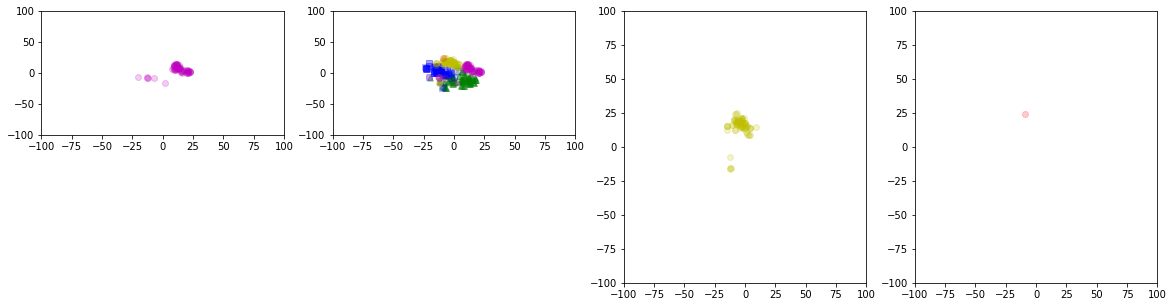

In [38]:
plt.figure(figsize=(20,5))

plt.subplot(141)
plt.plot(tsne[:,0][y_sub_rdkit==0], tsne[:,1][y_sub_rdkit==0], "g^", alpha=0.2)
plt.axis([-100, 100, -100, 100])

plt.subplot(142)
plt.plot(tsne[:,0][y_sub_rdkit==1], tsne[:,1][y_sub_rdkit==1], "bs", alpha=0.2)
plt.axis([-100, 100, -100, 100])

plt.subplot(143)
plt.plot(tsne[:,0][y_sub_rdkit==2], tsne[:,1][y_sub_rdkit==2], "yo", alpha=0.2)
plt.axis([-100, 100, -100, 100])

plt.subplot(144)
plt.plot(tsne[:,0][y_sub_rdkit==3], tsne[:,1][y_sub_rdkit==3], "ro", alpha=0.2)
plt.axis([-100, 100, -100, 100])

plt.subplot(241)
plt.plot(tsne[:,0][y_sub_rdkit==4], tsne[:,1][y_sub_rdkit==4], "mo", alpha=0.2)
plt.axis([-100, 100, -100, 100])

plt.subplot(242)
plt.plot(tsne[:,0][y_sub_rdkit==5], tsne[:,1][y_sub_rdkit==5], "co", alpha=0.2)
plt.axis([-100, 100, -100, 100])



plt.plot(tsne[:,0][y_sub_rdkit==0], tsne[:,1][y_sub_rdkit==0], "g^", alpha=0.2)
plt.plot(tsne[:,0][y_sub_rdkit==1], tsne[:,1][y_sub_rdkit==1], "bs", alpha=0.2)
plt.plot(tsne[:,0][y_sub_rdkit==2], tsne[:,1][y_sub_rdkit==2], "yo", alpha=0.2)
plt.plot(tsne[:,0][y_sub_rdkit==3], tsne[:,1][y_sub_rdkit==3], "ro", alpha=0.2)
plt.plot(tsne[:,0][y_sub_rdkit==4], tsne[:,1][y_sub_rdkit==4], "mo", alpha=0.2)
plt.plot(tsne[:,0][y_sub_rdkit==5], tsne[:,1][y_sub_rdkit==5], "co", alpha=0.2)
plt.axis([-100, 100, -100, 100])

plt.show()

/usr/local/lib/python3.7/dist-packages/rdkit/Chem/Draw/IPythonConsole.py:243: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  % (maxMols))


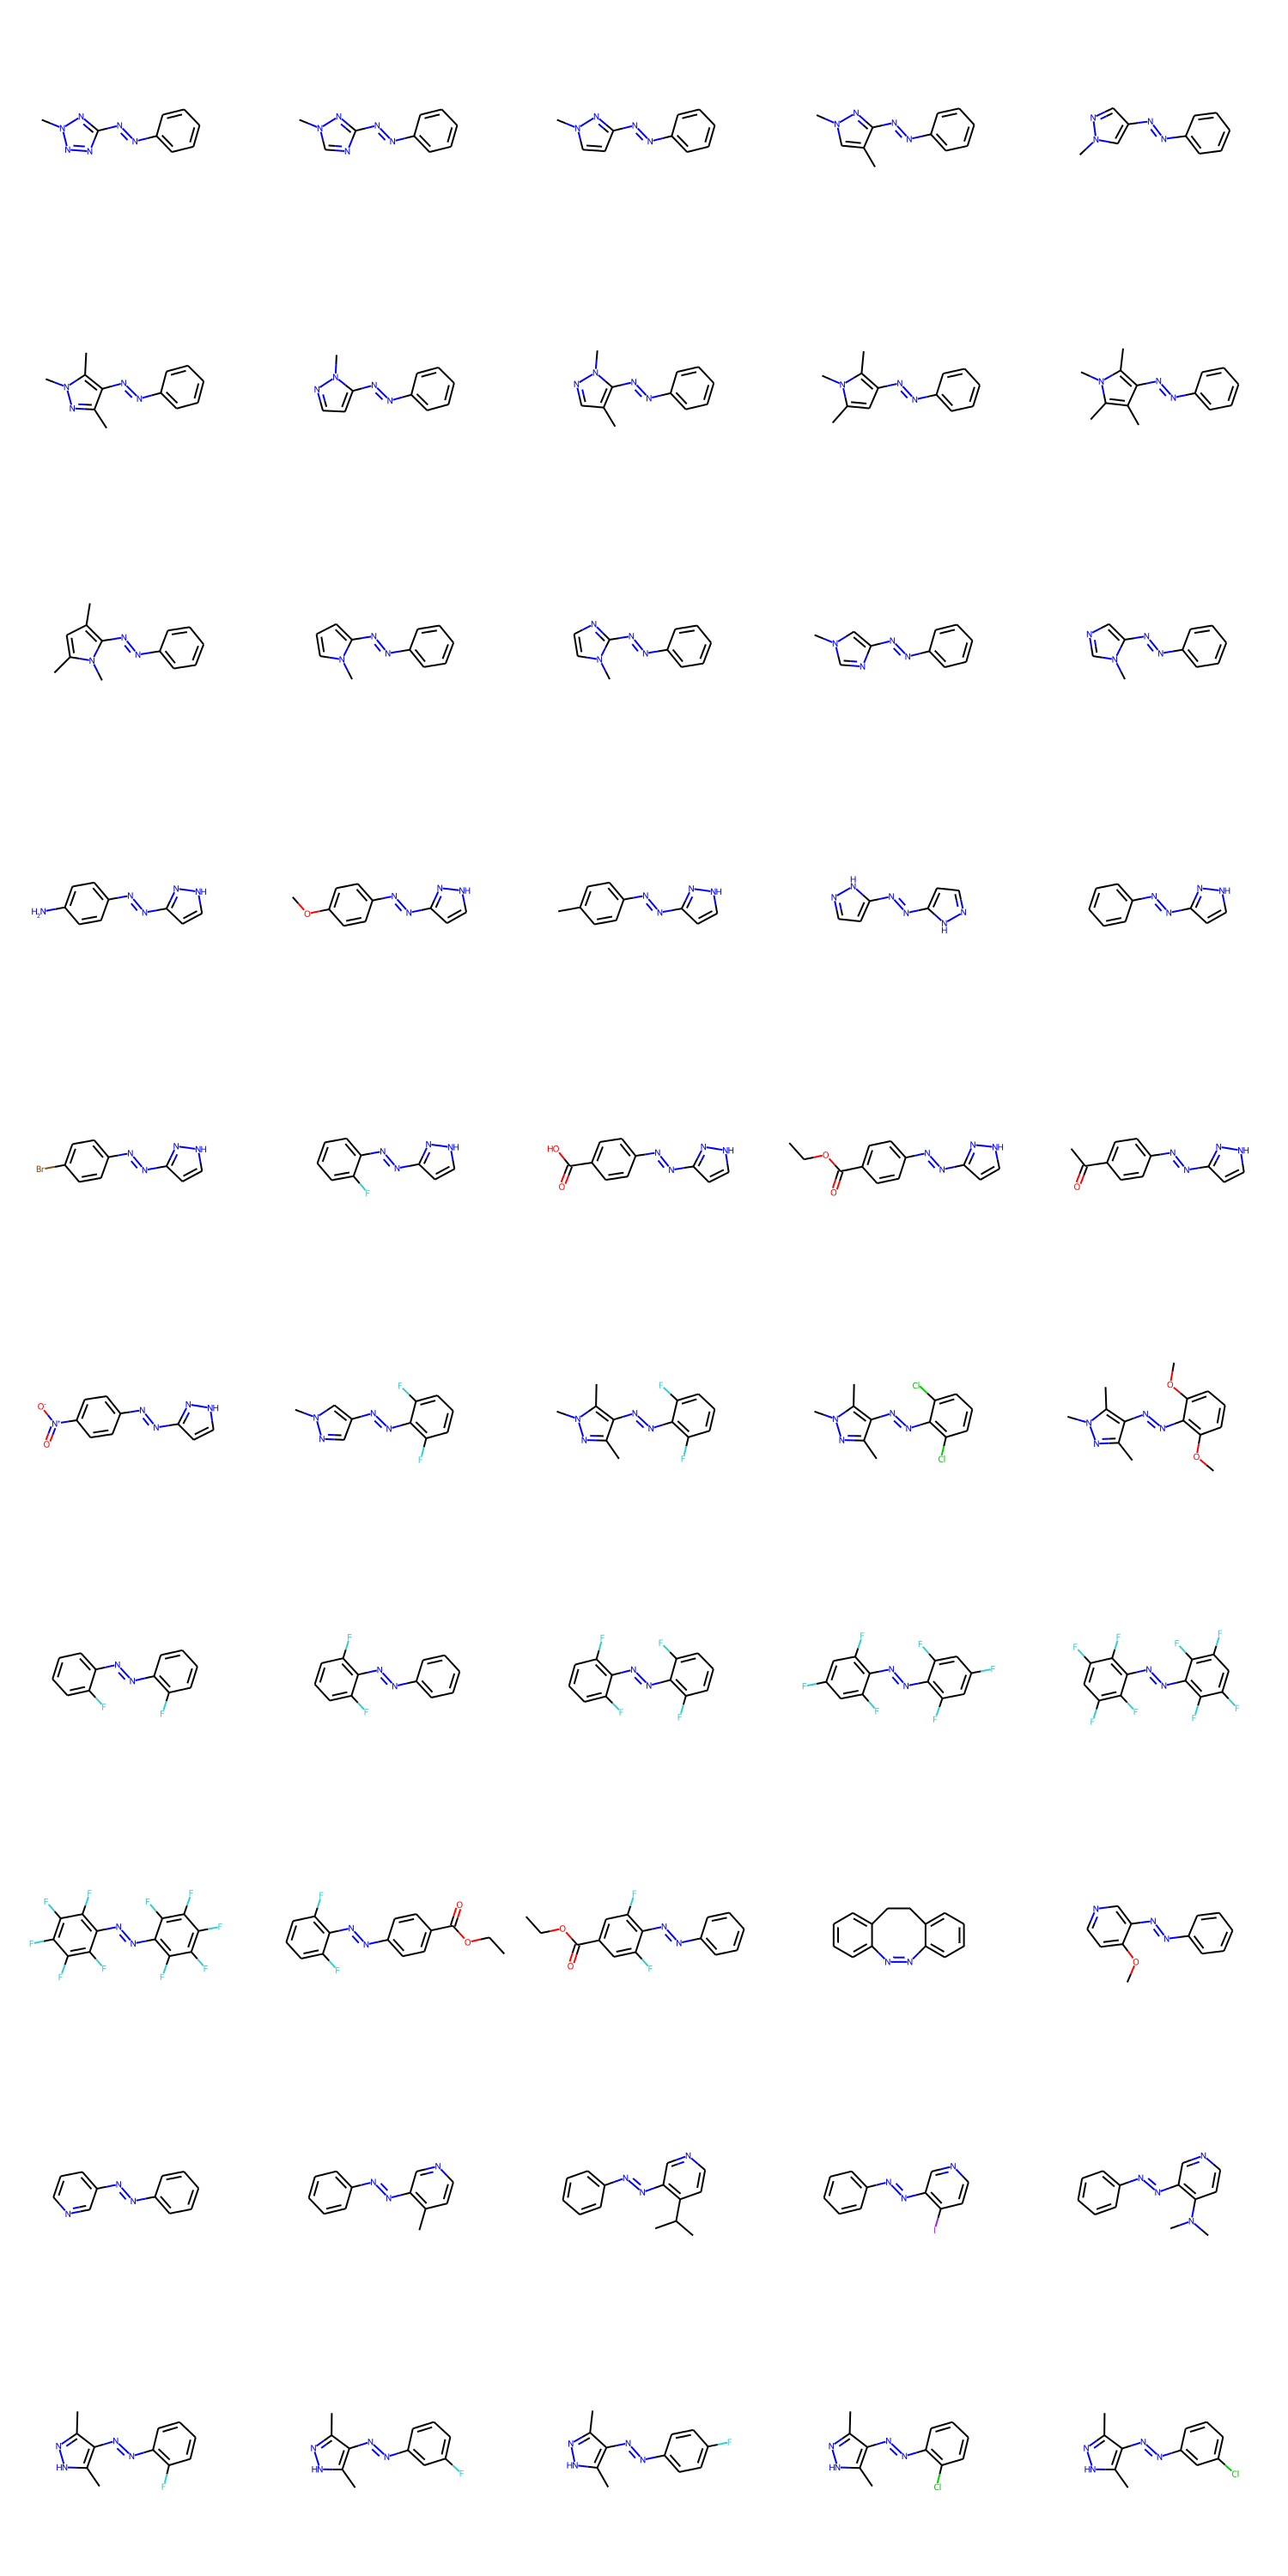

In [39]:
from rdkit.Chem import Draw
mols = [Chem.MolFromSmiles(x) for x in smiles[rk_0]] # draw molecules from our rk_0 cluster
Draw.MolsToGridImage(mols,molsPerRow=5,subImgSize=(300, 300))

/usr/local/lib/python3.7/dist-packages/rdkit/Chem/Draw/IPythonConsole.py:243: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  % (maxMols))


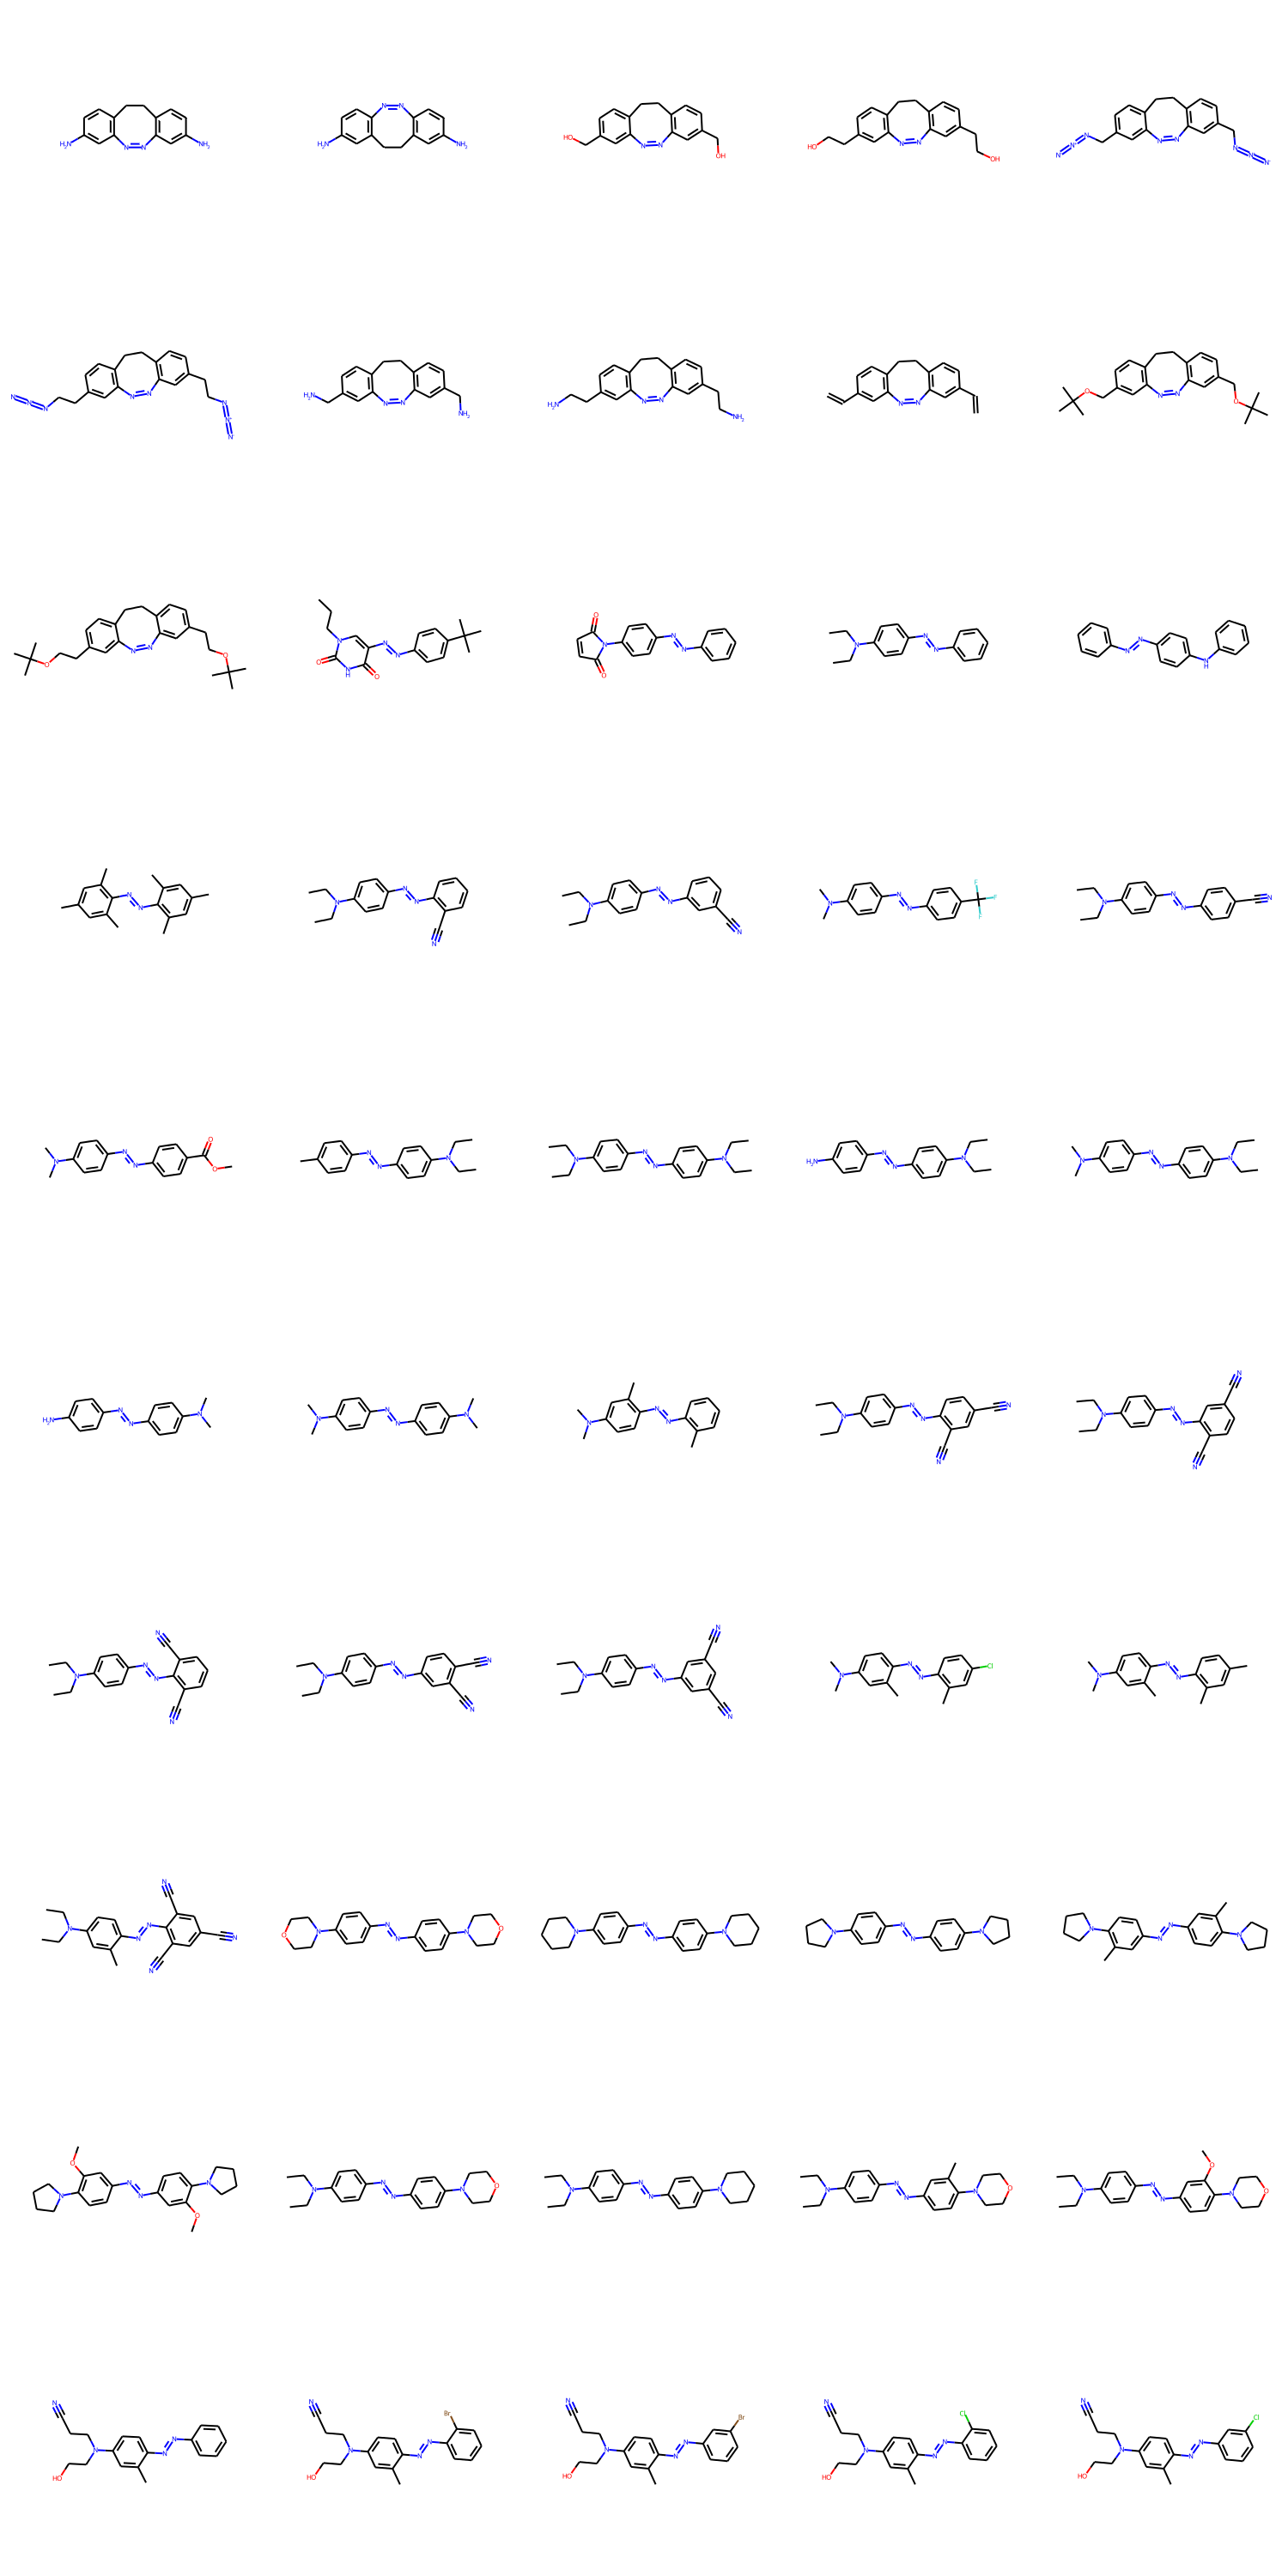

In [40]:
mols = [Chem.MolFromSmiles(x) for x in smiles[rk_1]] # draw molecules from our rk_1 cluster
Draw.MolsToGridImage(mols,molsPerRow=5,subImgSize=(300, 300))

/usr/local/lib/python3.7/dist-packages/rdkit/Chem/Draw/IPythonConsole.py:243: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  % (maxMols))


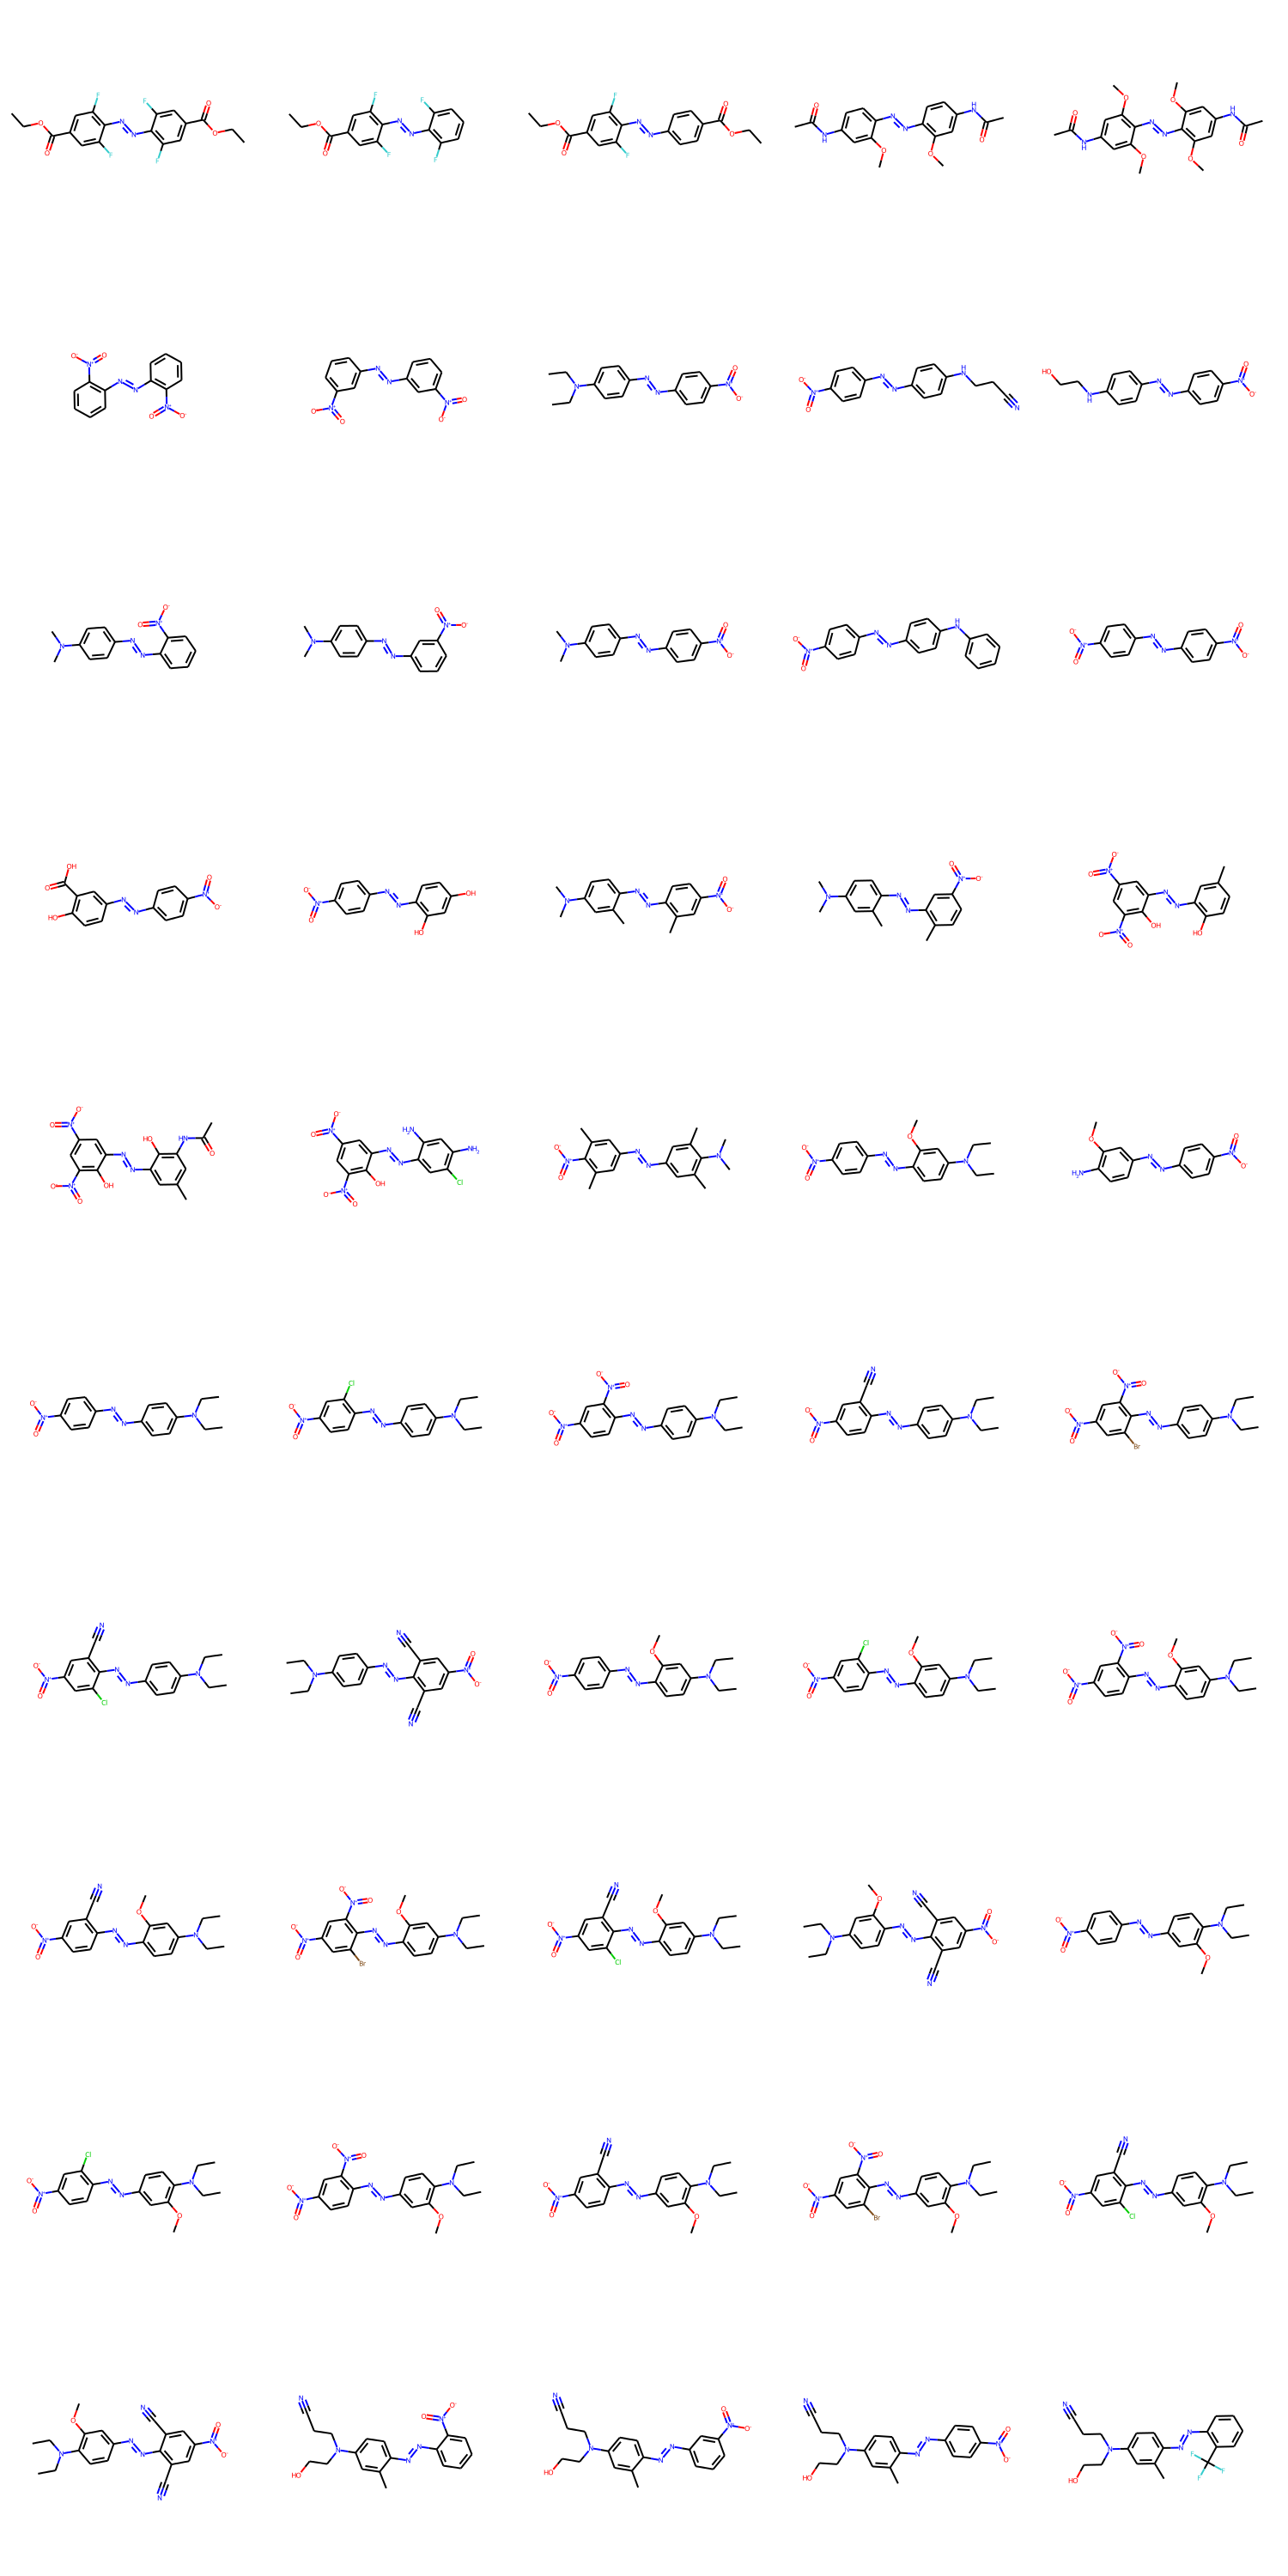

In [41]:
mols = [Chem.MolFromSmiles(x) for x in smiles[rk_2]] # draw molecules from our rk_2 cluster
Draw.MolsToGridImage(mols,molsPerRow=5,subImgSize=(300, 300))

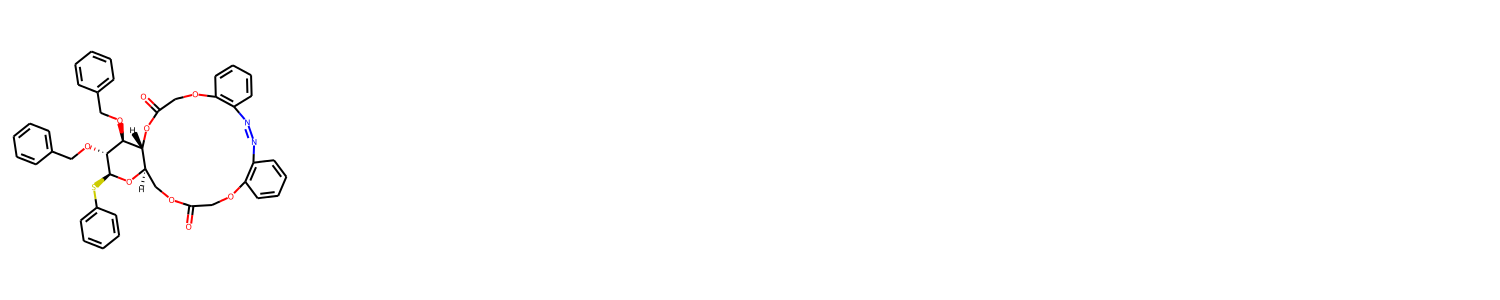

In [42]:
mols = [Chem.MolFromSmiles(x) for x in smiles[rk_3]] # draw molecules from our rk_3 cluster
Draw.MolsToGridImage(mols,molsPerRow=5,subImgSize=(300, 300))

/usr/local/lib/python3.7/dist-packages/rdkit/Chem/Draw/IPythonConsole.py:243: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  % (maxMols))


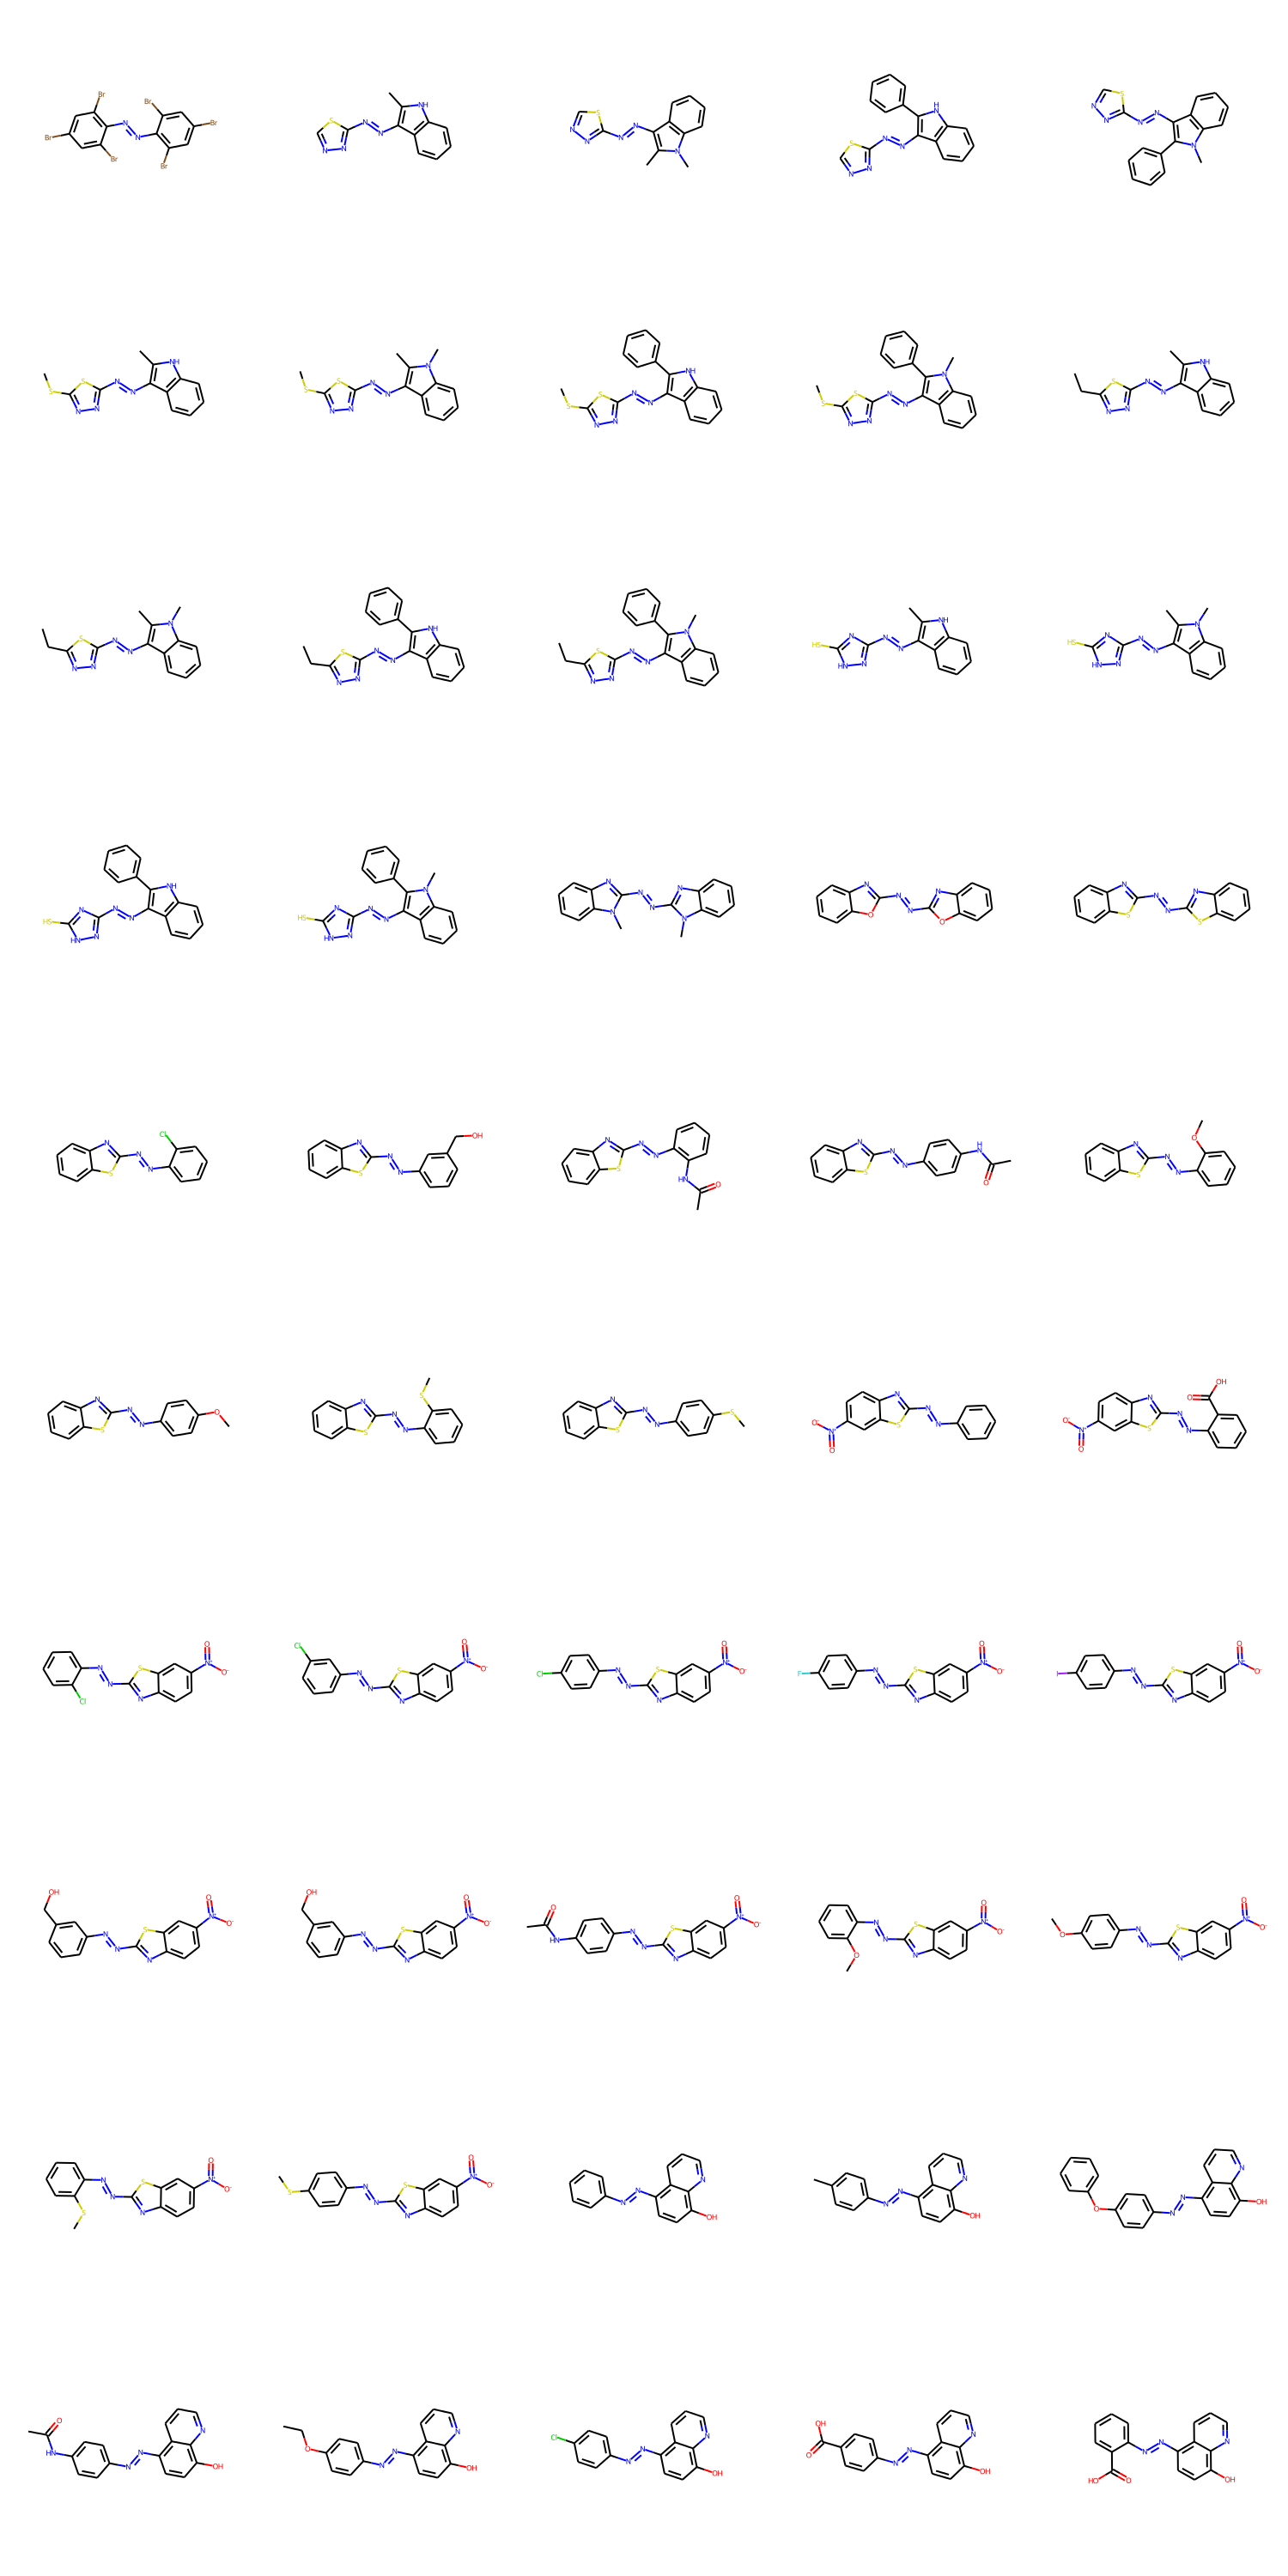

In [43]:
mols = [Chem.MolFromSmiles(x) for x in smiles[rk_4]] # draw molecules from our rk_4 cluster
Draw.MolsToGridImage(mols,molsPerRow=5,subImgSize=(300, 300))

# Morgan Fingerprints

In [137]:
## Get Morgan fingerprints, note the parameters!
# This is a popular method to turn molecules of any shape 
# into fixed sized vectors of binary data. The authors of the paper also use this method.
morgan_fingerprints = [AllChem.GetMorganFingerprintAsBitVect(mol, radius=3, nBits=2048) for mol in rdkit_mols]
morgan_fingerprints = np.asarray(morgan_fingerprints)

In [138]:
# Turn into pandas dataframe and add smiles as a first column
morgan_fingerprints = pd.DataFrame(data = morgan_fingerprints)
morgan_fingerprints.insert(0, "SMILES", smiles_list)

In [139]:
morgan_fingerprints

SMILES  0  1  ...  2045  2046  2047
0                         C[N]1N=NC(=N1)N=NC2=CC=CC=C2  0  0  ...     0     0     0
1                         C[N]1C=NC(=N1)N=NC2=CC=CC=C2  0  0  ...     0     0     0
2                         C[N]1C=CC(=N1)N=NC2=CC=CC=C2  0  0  ...     0     0     0
3                      C[N]1C=C(C)C(=N1)N=NC2=CC=CC=C2  0  0  ...     0     0     0
4                         C[N]1C=C(C=N1)N=NC2=CC=CC=C2  0  0  ...     0     0     0
..                                                 ... .. ..  ...   ...   ...   ...
400  OC%38=C%39N=CC=CC%39=C(/N=N/C%40=NC%41=CC(C)=C...  0  0  ...     0     0     0
401  OC%42=C%43N=CC=CC%43=C(/N=N/C%44=NC%45=CC=CC=C...  0  0  ...     0     0     0
402  N#CC1C(SC(/N=N/C2=NC(C=CC([N+]([O-])=O)=C3)=C3...  0  0  ...     0     0     0
403  N#Cc5c(c6ccc(Cl)cc6)c(/N=N/C7=NC(C=CC([N+]([O-...  0  0  ...     0     0     0
404  N#CC9C(SC(/N=N/C%10=NC(C=CC([N+]([O-])=O)=C%11...  0  0  ...     0     0     1

[405 rows x 2049 columns]

In [140]:
morgan = morgan_fingerprints.to_csv("morgan_fingerprints.csv")

In [141]:
# Next, rdkit's own descriptors
from rdkit.Chem import Descriptors

In [142]:
from rdkit.Chem import rdMolDescriptors

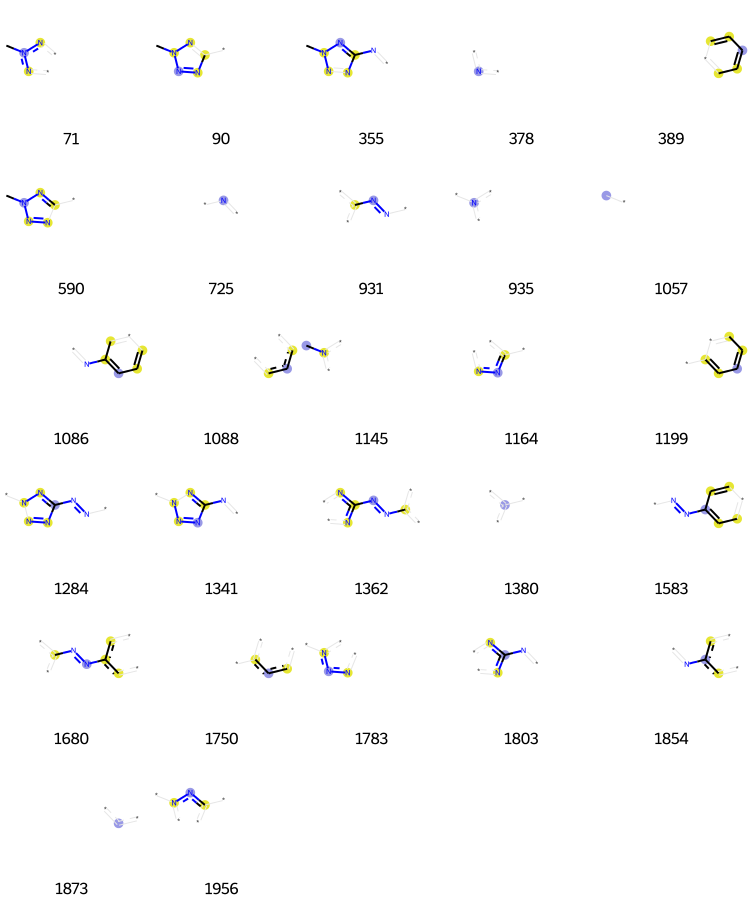

In [157]:
bi = {}
smiles = photoswitches['SMILES'].values
morgan_photo= Chem.MolFromSmiles(smiles[0])
fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(morgan_photo, radius=2, bitInfo=bi)

morgan_mols = [(morgan_photo,x,bi) for x in fp.GetOnBits()]
Draw.DrawMorganBits(morgan_mols,molsPerRow=5,legends=[str(x) for x in fp.GetOnBits()])





In [ ]:
# Write a dictionary of name:function pairs for all descriptors
all_descriptors = {d[0]: d[1] for d in Descriptors.descList}

In [ ]:
# Initialise a new pandas df
rdkit_descriptors = pd.DataFrame(data = {"SMILES": np.array((smiles_list)) })
rdkit_descriptors

In [ ]:
# Compute each descriptor (outer loop) for each molecule(inside)
for feature in all_descriptors:
    values = []
    for mol in rdkit_mols:
        values += [all_descriptors[feature](mol)]
    rdkit_descriptors[feature] = values

rdkit_descriptors

In [ ]:

# Use this line to get all columns of type float
# columns = chembl.columns[np.where(chembl.dtypes == "float64")] 

chembl_subset = chembl[columns].dropna()
chembl_subset

In [ ]:
rdkit_descriptors.to_csv("rdkit_descriptors.csv")

In [ ]:
rdkit_descriptors.isnull().sum()

In [ ]:
rdkit_columns = rdkit_descriptors.columns[1:].values.tolist()
#new_mordred_descriptors
rdkit_columns =rdkit_descriptors.columns[np.where(rdkit_descriptors.dtypes != "object")] 
rdkit_descriptors_subset = rdkit_descriptors[rdkit_columns].dropna()
rdkit_descriptors_subset

In [ ]:
rdkit_descriptors.columns

In [ ]:
X_sub_rdkit = rdkit_descriptors_subset.to_numpy()


# PCA 
X_sub_rdkit_scaled = StandardScaler().fit_transform(X_sub_rdkit)
X_sub_rdkit_pca = PCA(n_components=0.9).fit_transform(X_sub_rdkit_scaled)
X_sub_rdkit_pca

In [ ]:
# KMeans
range_of_ks = range(1,16)
kmeans_per_k = [KMeans(n_clusters=k).fit(X_sub_rdkit_pca) for k in range_of_ks]

inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 3.5))
plt.plot(range_of_ks, inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.show()

In [ ]:
silhouette_scores = [silhouette_score(X_sub_rdkit_pca, model.labels_)
                     for model in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3.5))
plt.plot(range_of_ks[1:], silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

In [ ]:
y_sub_rdkit = KMeans(13).fit_predict(X_sub_rdkit_pca)
y_sub_rdkit

In [ ]:
rndfor = RandomForestClassifier(n_estimators=500)
rndfor.fit(X_sub_rdkit, y_sub_rdkit)

In [ ]:
for name, imp in zip(rdkit_descriptors_subset.columns, rndfor.feature_importances_):
    print(name.ljust(20), round(imp,2))

# MORDERD Descriptors

In [44]:
# Finally, mordred descriptors
from mordred import Calculator, descriptors, error

In [45]:
# Initialise a calculator -- mordred works weirdly this way...
calc = Calculator(descriptors)

In [46]:
# Wow, many descriptors, much wow
len(calc.descriptors)

1826

In [47]:
mordred_descriptors = calc.pandas(rdkit_mols)

 16%|█▌        | 63/405 [00:26<05:22,  1.06it/s]

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████| 405/405 [02:44<00:00,  2.46it/s]


In [48]:
mordred_descriptors

ABC      ABCGG  nAcid  nBase  ...  Zagreb1  Zagreb2  mZagreb1  mZagreb2
0    10.715992   9.304580      2      0  ...     68.0     75.0  3.833333  3.166667
1    10.715992   9.304580      0      0  ...     68.0     75.0  3.833333  3.166667
2    10.715992   9.304580      0      0  ...     68.0     75.0  3.833333  3.166667
3    11.492048  10.070849      0      0  ...     74.0     83.0  4.694444  3.361111
4    10.715992   9.304580      0      0  ...     68.0     75.0  3.833333  3.166667
..         ...        ...    ...    ...  ...      ...      ...       ...       ...
400  19.217852  14.577842      0      0  ...    132.0    158.0  7.000000  5.138889
401  17.625299  13.419762      0      0  ...    120.0    143.0  5.277778  4.777778
402  22.005839  17.491326      0      1  ...    150.0    179.0  8.611111  6.166667
403  22.822336  17.990446      0      0  ...    156.0    186.0  9.472222  6.333333
404  23.420052  18.362473      0      1  ...    160.0    191.0  9.722222  6.666667

[405 rows x 1826 columns]

In [49]:
mordred_descriptors.isnull().sum()

ABC         0
ABCGG       0
nAcid       0
nBase       0
SpAbs_A     0
           ..
WPol        0
Zagreb1     0
Zagreb2     0
mZagreb1    0
mZagreb2    0
Length: 1826, dtype: int64

In [50]:
# It seems that unfortunately some descriptors cannot be computed. To filter this, 
# we find all columns that are of data type "object", since those contain non-numerical values usually.
error_columns = []
for i, e in enumerate(mordred_descriptors.dtypes):
    if e=="object":
        error_columns += [i]
#error_columns

In [51]:
# use .drop to remove the affected columns 
mordred_descriptors = mordred_descriptors.drop(mordred_descriptors.columns[error_columns], axis=1)

In [52]:
# and remove columns containing NAN data, but I don't think this actually does anything...
mordred_descriptors = mordred_descriptors.dropna(axis=1)

In [53]:
# again, insert first SMILES column
mordred_descriptors.insert(0, "SMILES", smiles_list)
mordred_descriptors

SMILES  ...  mZagreb2
0                         C[N]1N=NC(=N1)N=NC2=CC=CC=C2  ...  3.166667
1                         C[N]1C=NC(=N1)N=NC2=CC=CC=C2  ...  3.166667
2                         C[N]1C=CC(=N1)N=NC2=CC=CC=C2  ...  3.166667
3                      C[N]1C=C(C)C(=N1)N=NC2=CC=CC=C2  ...  3.361111
4                         C[N]1C=C(C=N1)N=NC2=CC=CC=C2  ...  3.166667
..                                                 ...  ...       ...
400  OC%38=C%39N=CC=CC%39=C(/N=N/C%40=NC%41=CC(C)=C...  ...  5.138889
401  OC%42=C%43N=CC=CC%43=C(/N=N/C%44=NC%45=CC=CC=C...  ...  4.777778
402  N#CC1C(SC(/N=N/C2=NC(C=CC([N+]([O-])=O)=C3)=C3...  ...  6.166667
403  N#Cc5c(c6ccc(Cl)cc6)c(/N=N/C7=NC(C=CC([N+]([O-...  ...  6.333333
404  N#CC9C(SC(/N=N/C%10=NC(C=CC([N+]([O-])=O)=C%11...  ...  6.666667

[405 rows x 1428 columns]

In [54]:
#morgan = morgan_fingerprints.to_csv("morgan_fingerprints.csv")
# This is where I keep my csv file, you need to specify the path to your file!

# Use this line to get all columns of type float
# columns = chembl.columns[np.where(chembl.dtypes == "float64")] 

morgan_columns = mordred_descriptors.columns[1:].values.tolist()
#new_mordred_descriptors
morgan_columns

mordred_descriptors_subset = mordred_descriptors[morgan_columns].dropna()
mordred_descriptors_subset

ABC      ABCGG  nAcid  nBase  ...  Zagreb1  Zagreb2  mZagreb1  mZagreb2
0    10.715992   9.304580      2      0  ...     68.0     75.0  3.833333  3.166667
1    10.715992   9.304580      0      0  ...     68.0     75.0  3.833333  3.166667
2    10.715992   9.304580      0      0  ...     68.0     75.0  3.833333  3.166667
3    11.492048  10.070849      0      0  ...     74.0     83.0  4.694444  3.361111
4    10.715992   9.304580      0      0  ...     68.0     75.0  3.833333  3.166667
..         ...        ...    ...    ...  ...      ...      ...       ...       ...
400  19.217852  14.577842      0      0  ...    132.0    158.0  7.000000  5.138889
401  17.625299  13.419762      0      0  ...    120.0    143.0  5.277778  4.777778
402  22.005839  17.491326      0      1  ...    150.0    179.0  8.611111  6.166667
403  22.822336  17.990446      0      0  ...    156.0    186.0  9.472222  6.333333
404  23.420052  18.362473      0      1  ...    160.0    191.0  9.722222  6.666667

[405 rows x 1427 columns]

In [55]:
X_sub_morgan = mordred_descriptors_subset.to_numpy()


# PCA 
X_sub_morgan_scaled = StandardScaler().fit_transform(X_sub_morgan)
X_sub_morgan_pca = PCA(n_components=0.9).fit_transform(X_sub_morgan_scaled)
X_sub_morgan_pca

array([[-27.77118255,   2.25375041,   0.61748299, ...,  -3.69404124,
         -4.10968637,  -0.87720532],
       [-28.17588407,  -0.85114181,   1.75410178, ...,  -4.43703178,
         -4.40281166,  -0.60483219],
       [-27.92787864,  -5.25384518,   0.77128558, ...,   1.143308  ,
         -2.71858689,   0.82334525],
       ...,
       [ 37.95856198,   2.97445789,  17.94595813, ...,   1.27895911,
         -4.24516445,  -2.8700943 ],
       [ 32.63764927,  24.59617485,  24.73300482, ...,  -5.19910667,
          2.59721273,  -1.76155679],
       [ 46.64541384,   2.25239733,  15.30760162, ...,   2.32717086,
         -5.09690288,  -2.94142889]])

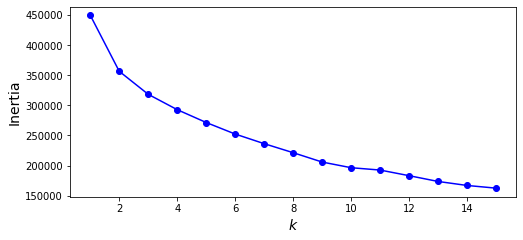

In [56]:
# KMeans
range_of_ks = range(1,16)
kmeans_per_k = [KMeans(n_clusters=k).fit(X_sub_morgan_pca) for k in range_of_ks]

inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 3.5))
plt.plot(range_of_ks, inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.show()

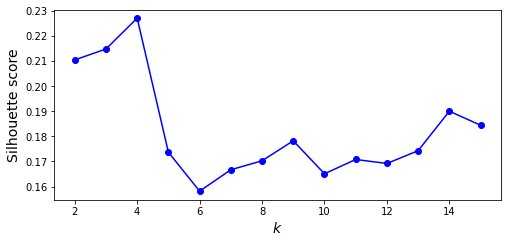

In [57]:
silhouette_scores = [silhouette_score(X_sub_morgan_pca, model.labels_)
                     for model in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3.5))
plt.plot(range_of_ks[1:], silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

In [58]:
y_sub_morgan = KMeans(4).fit_predict(X_sub_morgan_pca)
y_sub_morgan

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 2, 2, 2, 2, 2, 2, 2, 0, 2, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 0, 1, 1, 2, 1, 1, 0, 2, 1,
       1, 2, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 2, 1,
       1, 1, 1, 1, 2, 1, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 2, 2, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,

In [59]:
rndfor = RandomForestClassifier(n_estimators=1000, max_depth= 300)
rndfor.fit(X_sub_morgan, y_sub_morgan)


RandomForestClassifier(max_depth=300, n_estimators=1000)

In [122]:
for name, imp in zip(mordred_descriptors_subset.columns, np.sort(rndfor.feature_importances_)[::-1]):

  
    print(name.ljust(20), round(imp,5))

ABC                  0.01039
ABCGG                0.01001
nAcid                0.00983
nBase                0.00957
SpAbs_A              0.00924
SpMax_A              0.00916
SpDiam_A             0.00901
SpAD_A               0.00877
SpMAD_A              0.00827
LogEE_A              0.0082
VE1_A                0.00816
VE2_A                0.00808
VE3_A                0.0079
VR1_A                0.00783
VR2_A                0.00749
VR3_A                0.00735
nAromAtom            0.0072
nAromBond            0.00677
nAtom                0.00663
nHeavyAtom           0.00658
nSpiro               0.00651
nBridgehead          0.00636
nHetero              0.00633
nH                   0.00631
nB                   0.00626
nC                   0.00621
nN                   0.00617
nO                   0.0061
nS                   0.00608
nP                   0.00574
nF                   0.00572
nCl                  0.00561
nBr                  0.0056
nI                   0.00558
nX                 

In [62]:
tsne = TSNE().fit_transform(X_sub_morgan_pca)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


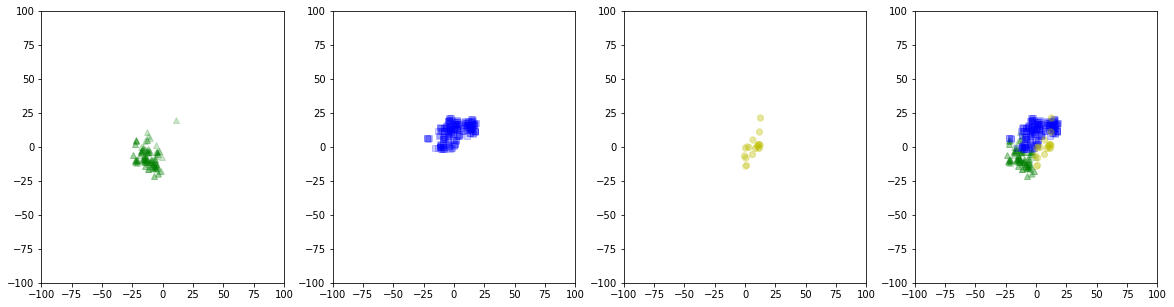

In [63]:
plt.figure(figsize=(20,5))

plt.subplot(141)
plt.plot(tsne[:,0][y_sub_morgan==0], tsne[:,1][y_sub_morgan==0], "g^", alpha=0.2)
plt.axis([-100, 100, -100, 100])

plt.subplot(142)
plt.plot(tsne[:,0][y_sub_morgan==1], tsne[:,1][y_sub_morgan==1], "bs", alpha=0.2)
plt.axis([-100, 100, -100, 100])

plt.subplot(143)
plt.plot(tsne[:,0][y_sub_morgan==2], tsne[:,1][y_sub_morgan==2], "yo", alpha=0.2)
plt.axis([-100, 100, -100, 100])

plt.subplot(144)
plt.plot(tsne[:,0][y_sub_morgan==0], tsne[:,1][y_sub_morgan==0], "g^", alpha=0.2)
plt.plot(tsne[:,0][y_sub_morgan==1], tsne[:,1][y_sub_morgan==1], "bs", alpha=0.2)
plt.plot(tsne[:,0][y_sub_morgan==2], tsne[:,1][y_sub_morgan==2], "yo", alpha=0.2)
plt.axis([-100, 100, -100, 100])

plt.show()

In [65]:
#checking to see which molecule is in which cluster
mk_0 = []
mk_1 = []
mk_2 = []
mk_3 = []
mk_4 = []
mk_5 = []
for k in range(len(y_sub_morgan)):
    if y_sub_morgan[k] == 0:
        mk_0.append(k)

for k in range(len(y_sub_morgan)):
    if y_sub_morgan[k] == 1:
        mk_1.append(k)

for k in range(len(y_sub_morgan)):
    if y_sub_morgan[k] == 2:
        mk_2.append(k)

for k in range(len(y_sub_morgan)):
    if y_sub_morgan[k] == 3:
        mk_3.append(k)


/usr/local/lib/python3.7/dist-packages/rdkit/Chem/Draw/IPythonConsole.py:243: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  % (maxMols))


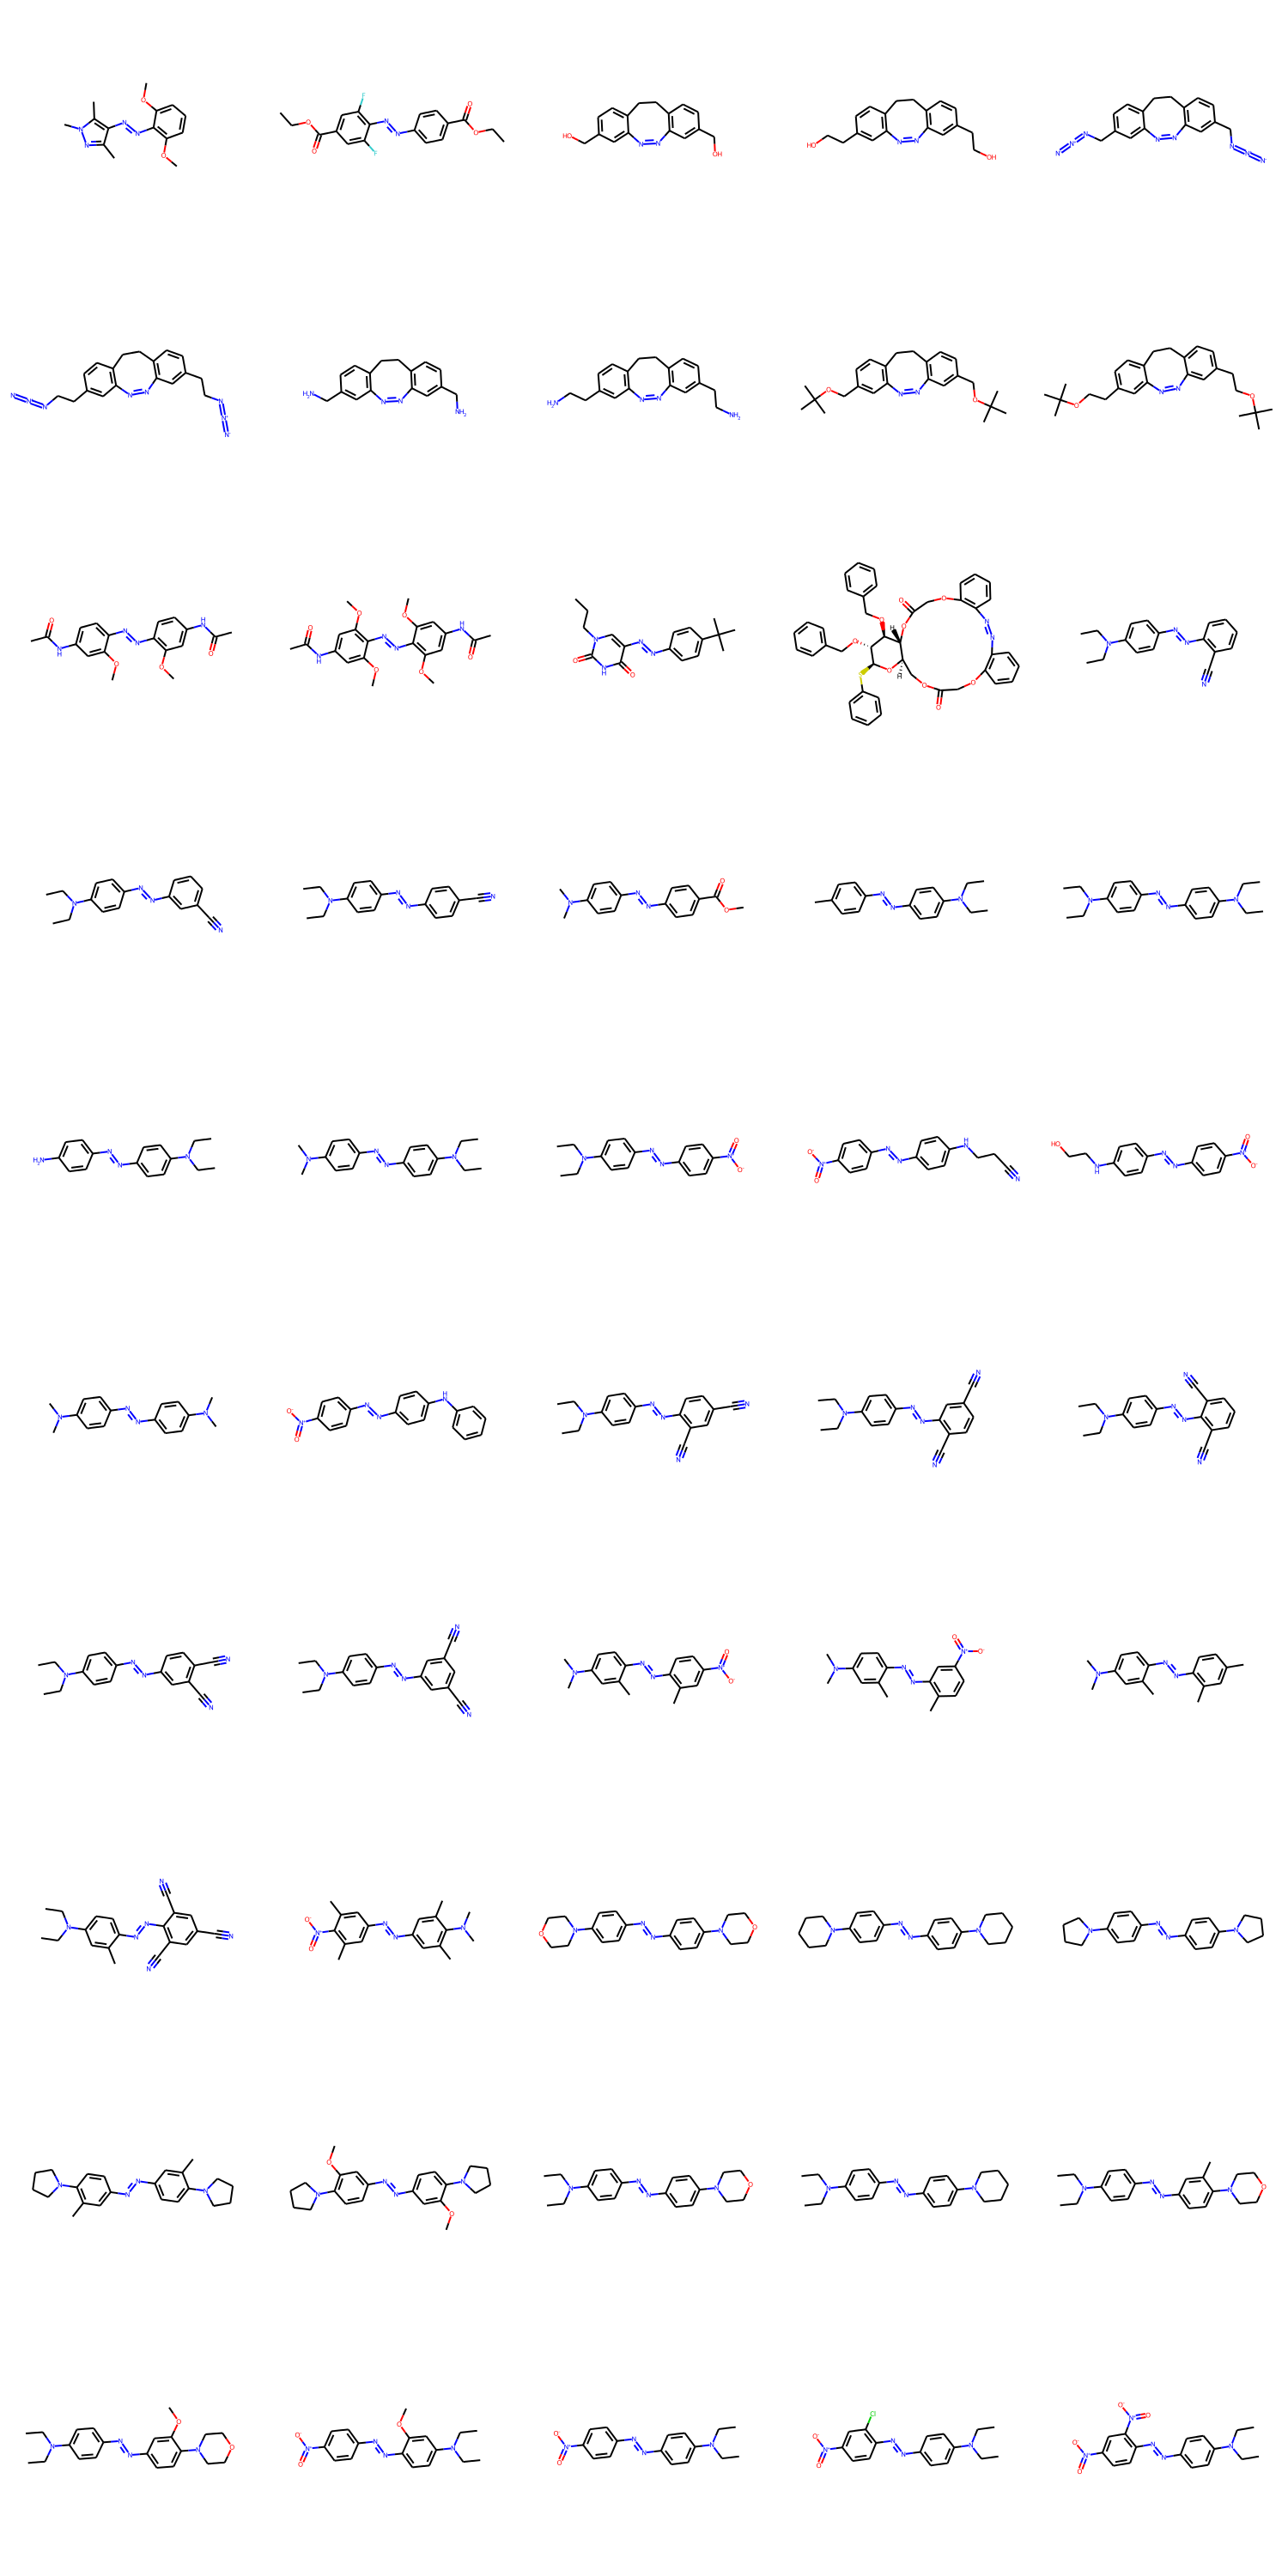

In [66]:
mols = [Chem.MolFromSmiles(x) for x in smiles[mk_0]] # draw molecules from our mk_0 cluster
Draw.MolsToGridImage(mols,molsPerRow=5,subImgSize=(300, 300))

/usr/local/lib/python3.7/dist-packages/rdkit/Chem/Draw/IPythonConsole.py:243: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  % (maxMols))


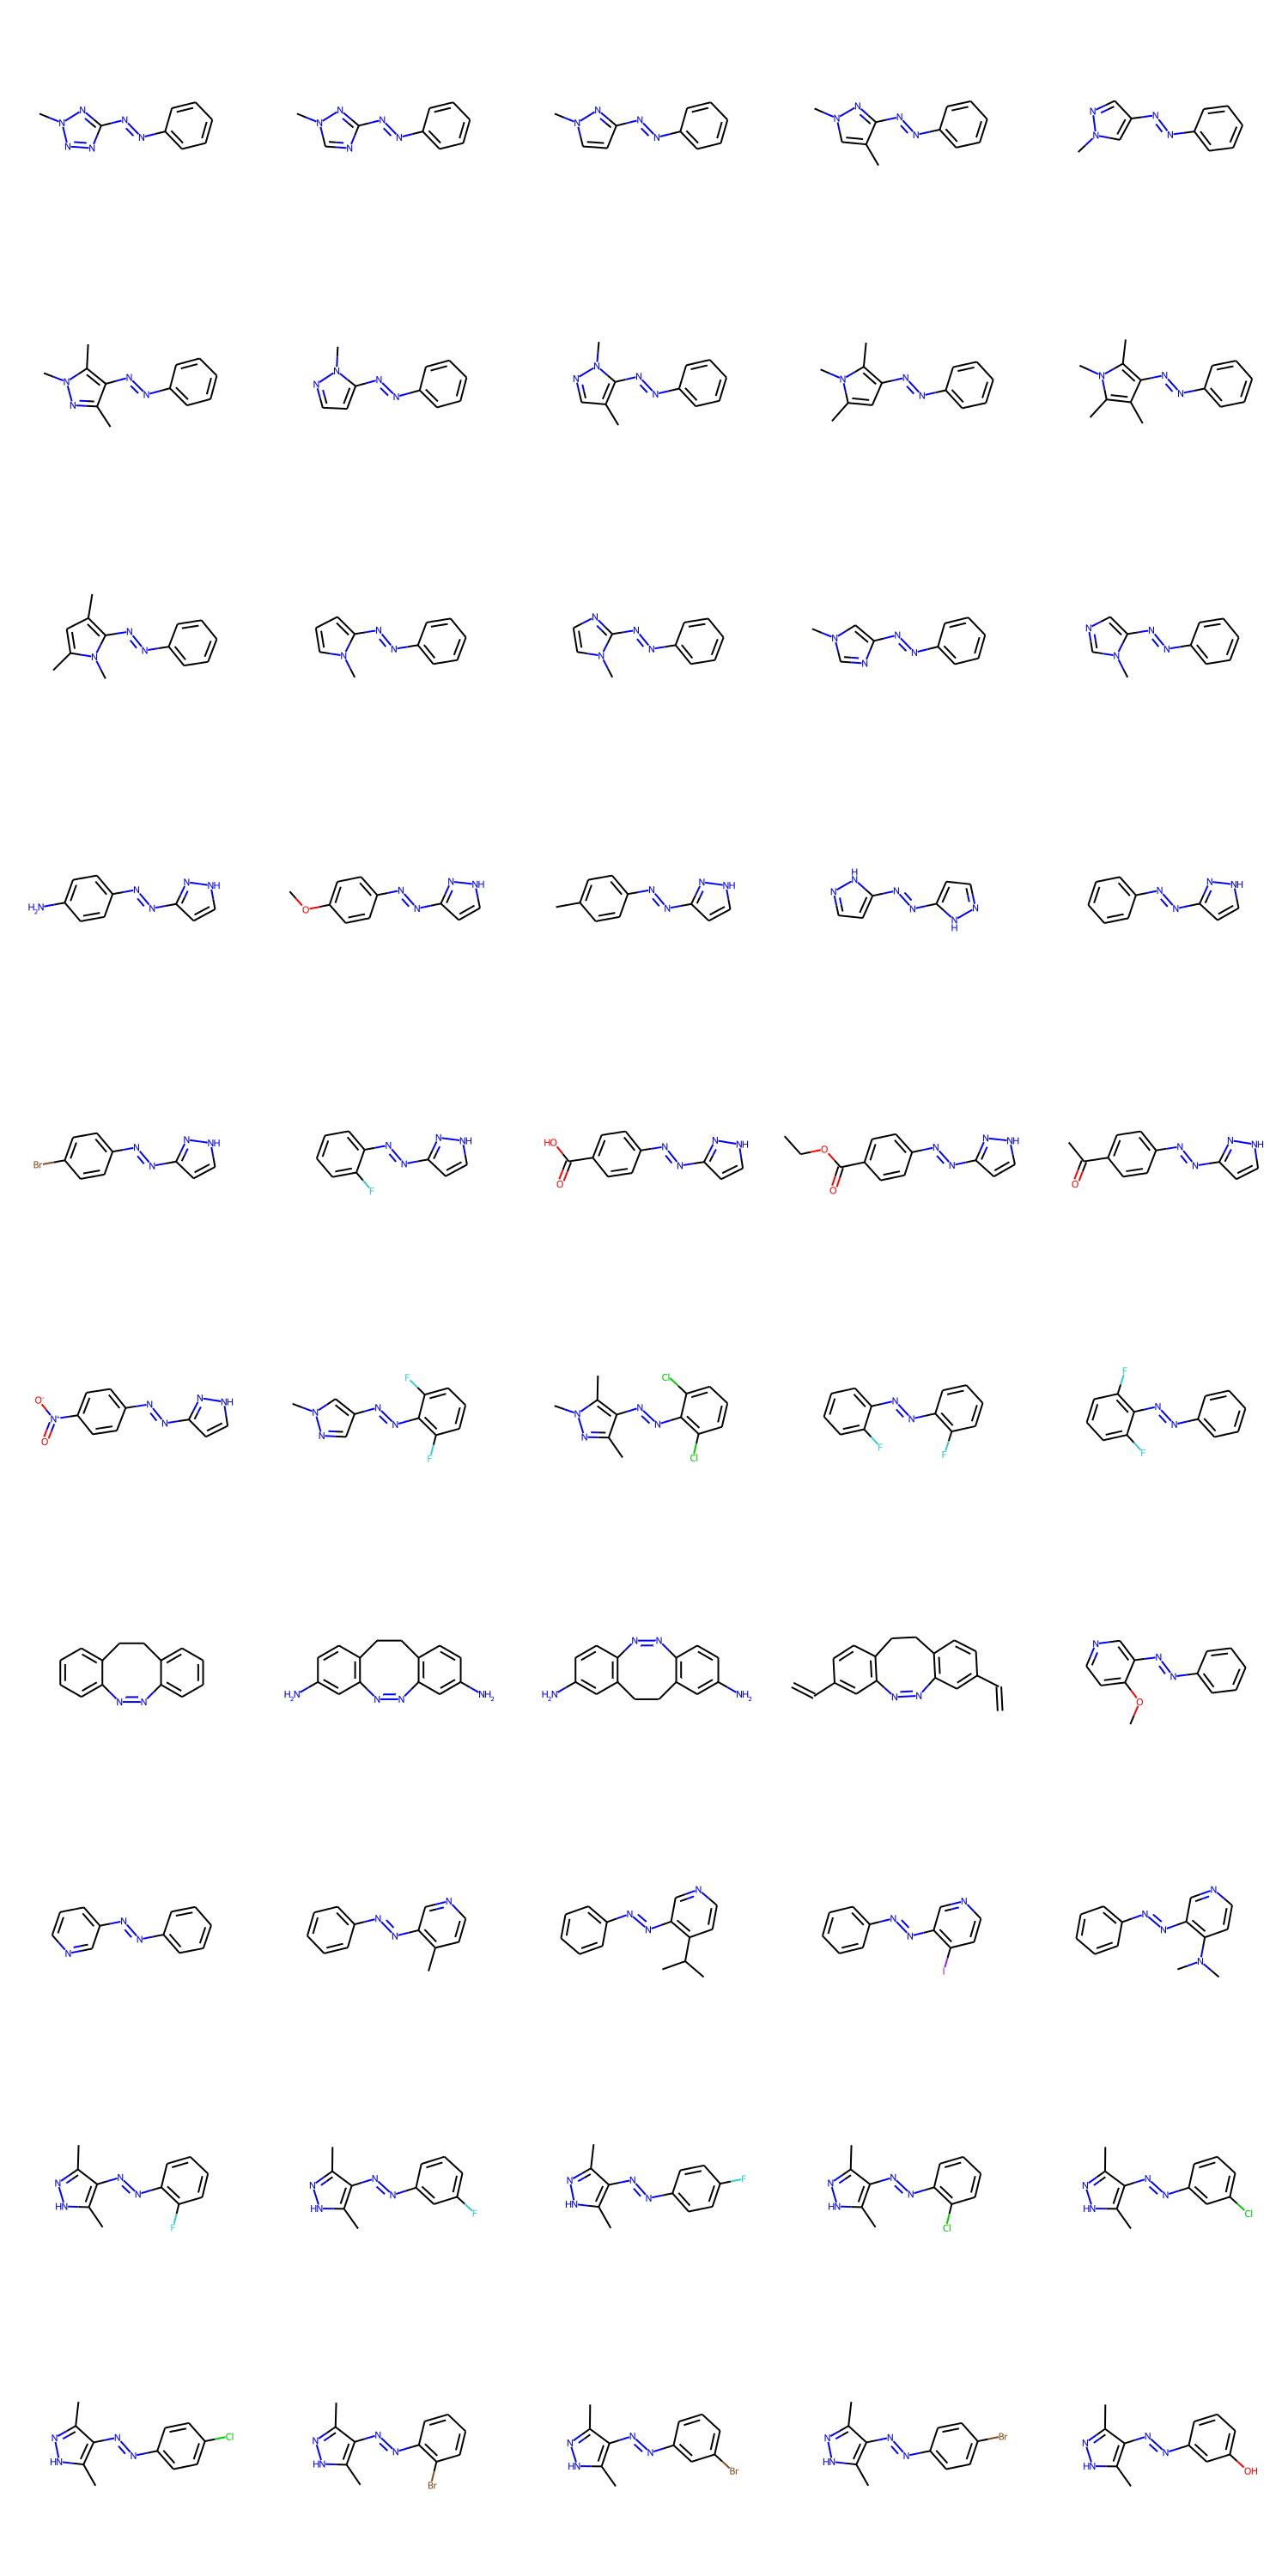

In [67]:
mols = [Chem.MolFromSmiles(x) for x in smiles[mk_1]] # draw molecules from our mk_1 cluster
Draw.MolsToGridImage(mols,molsPerRow=5,subImgSize=(300, 300))

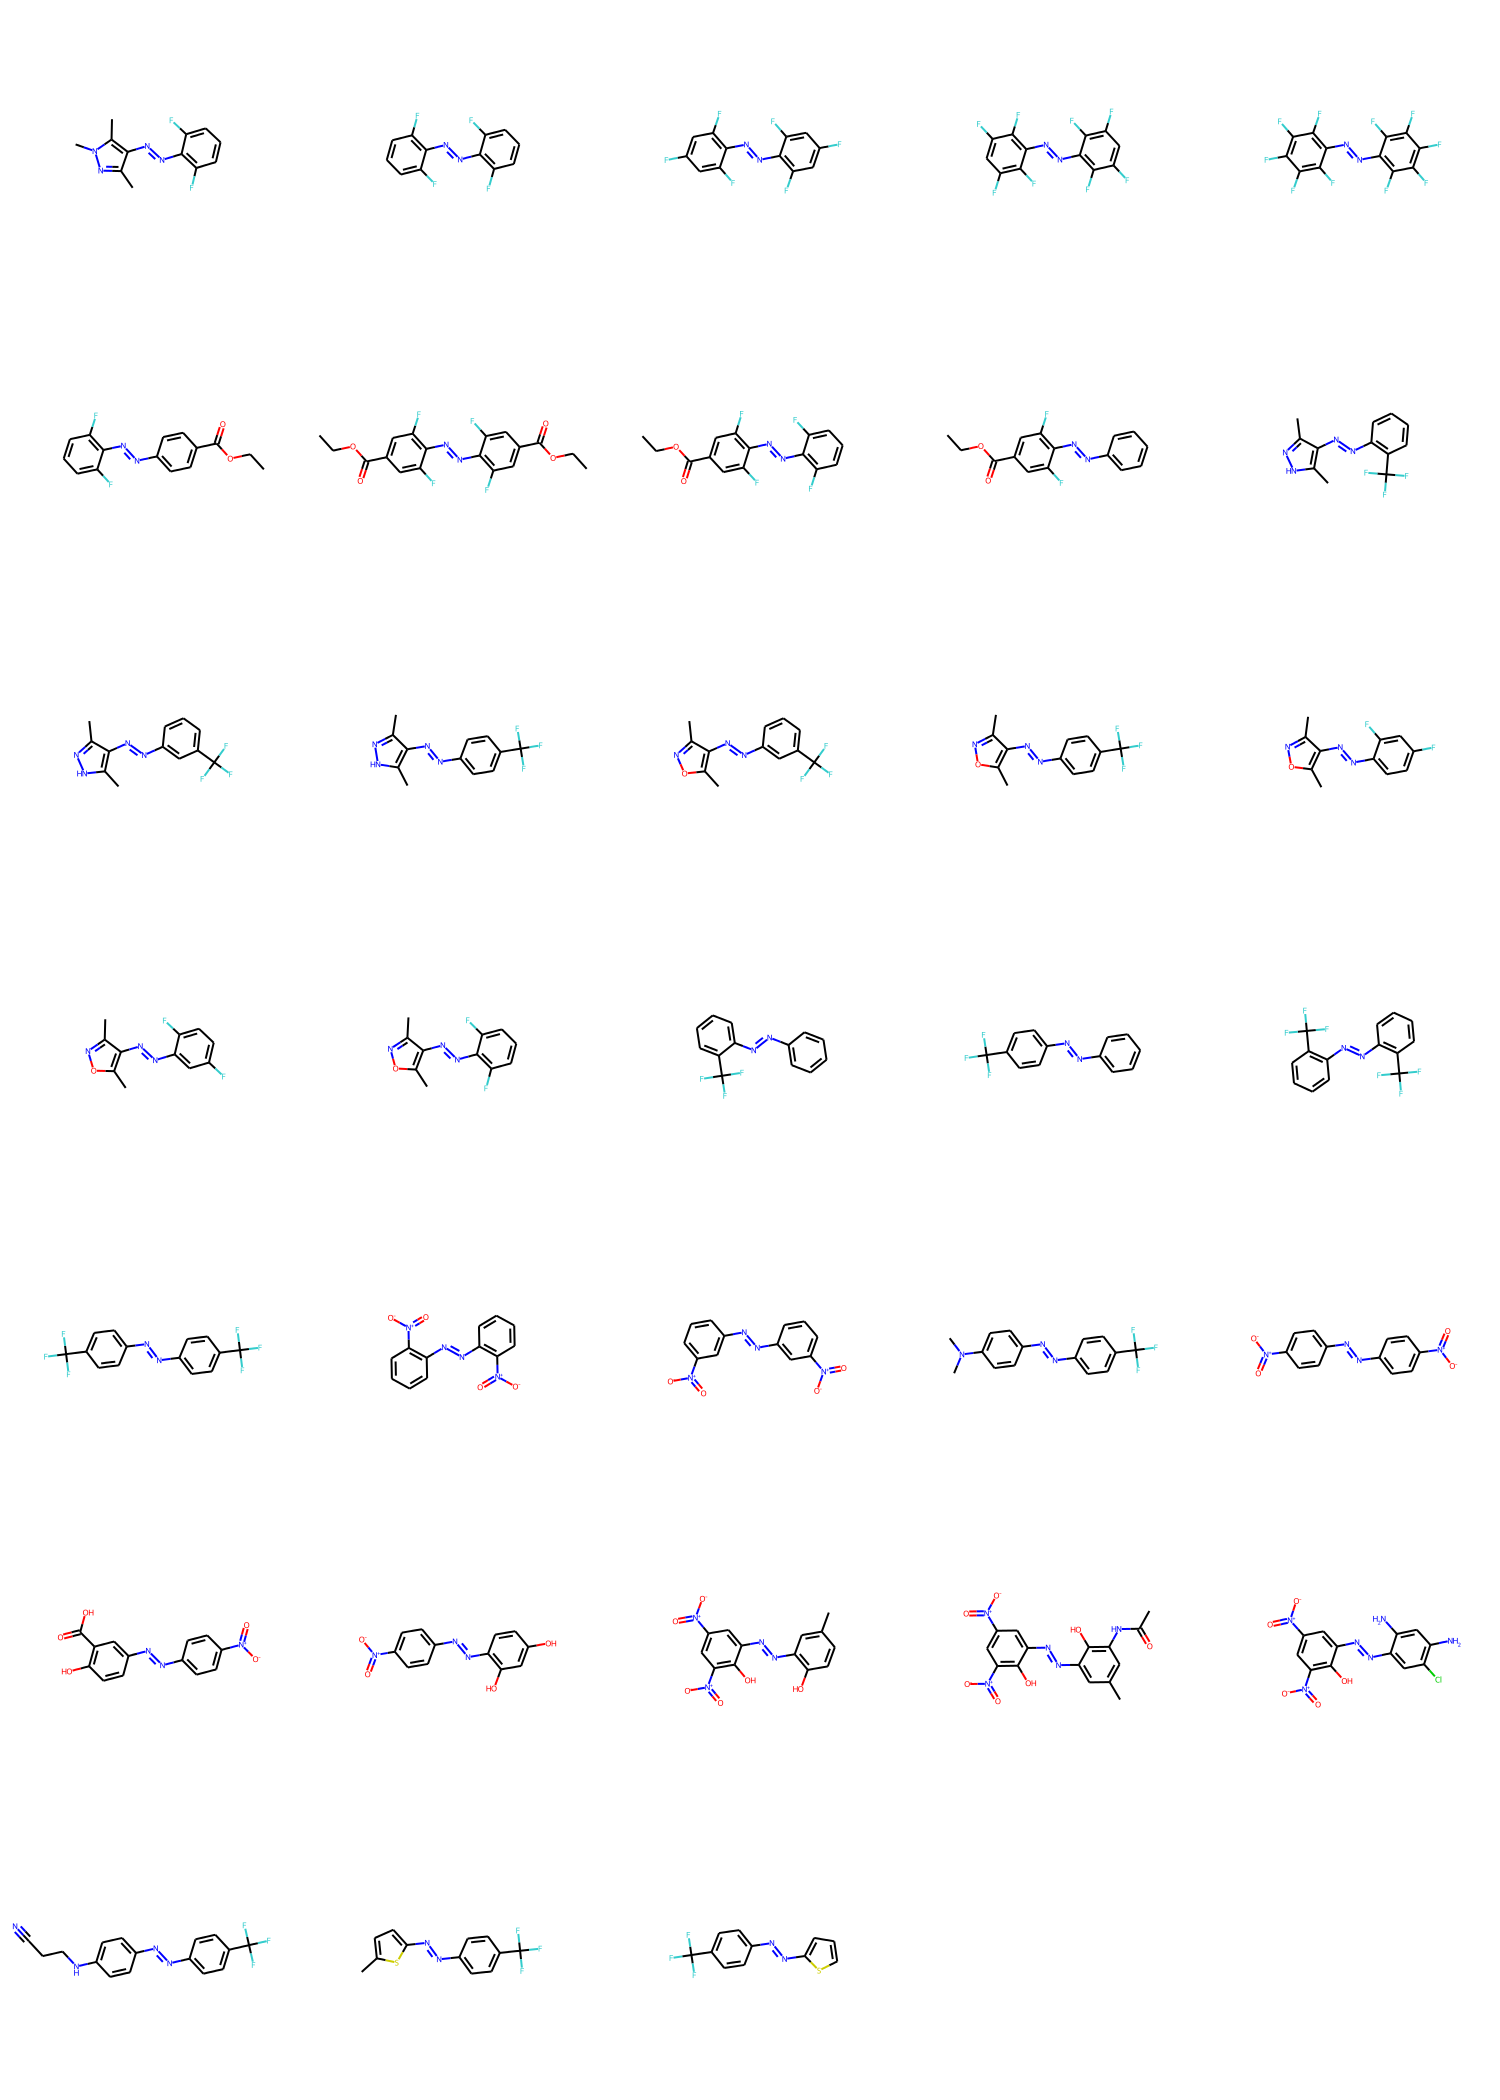

In [68]:
mols = [Chem.MolFromSmiles(x) for x in smiles[mk_2]] # draw molecules from our mk_2 cluster
Draw.MolsToGridImage(mols,molsPerRow=5,subImgSize=(300, 300))

/usr/local/lib/python3.7/dist-packages/rdkit/Chem/Draw/IPythonConsole.py:243: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  % (maxMols))


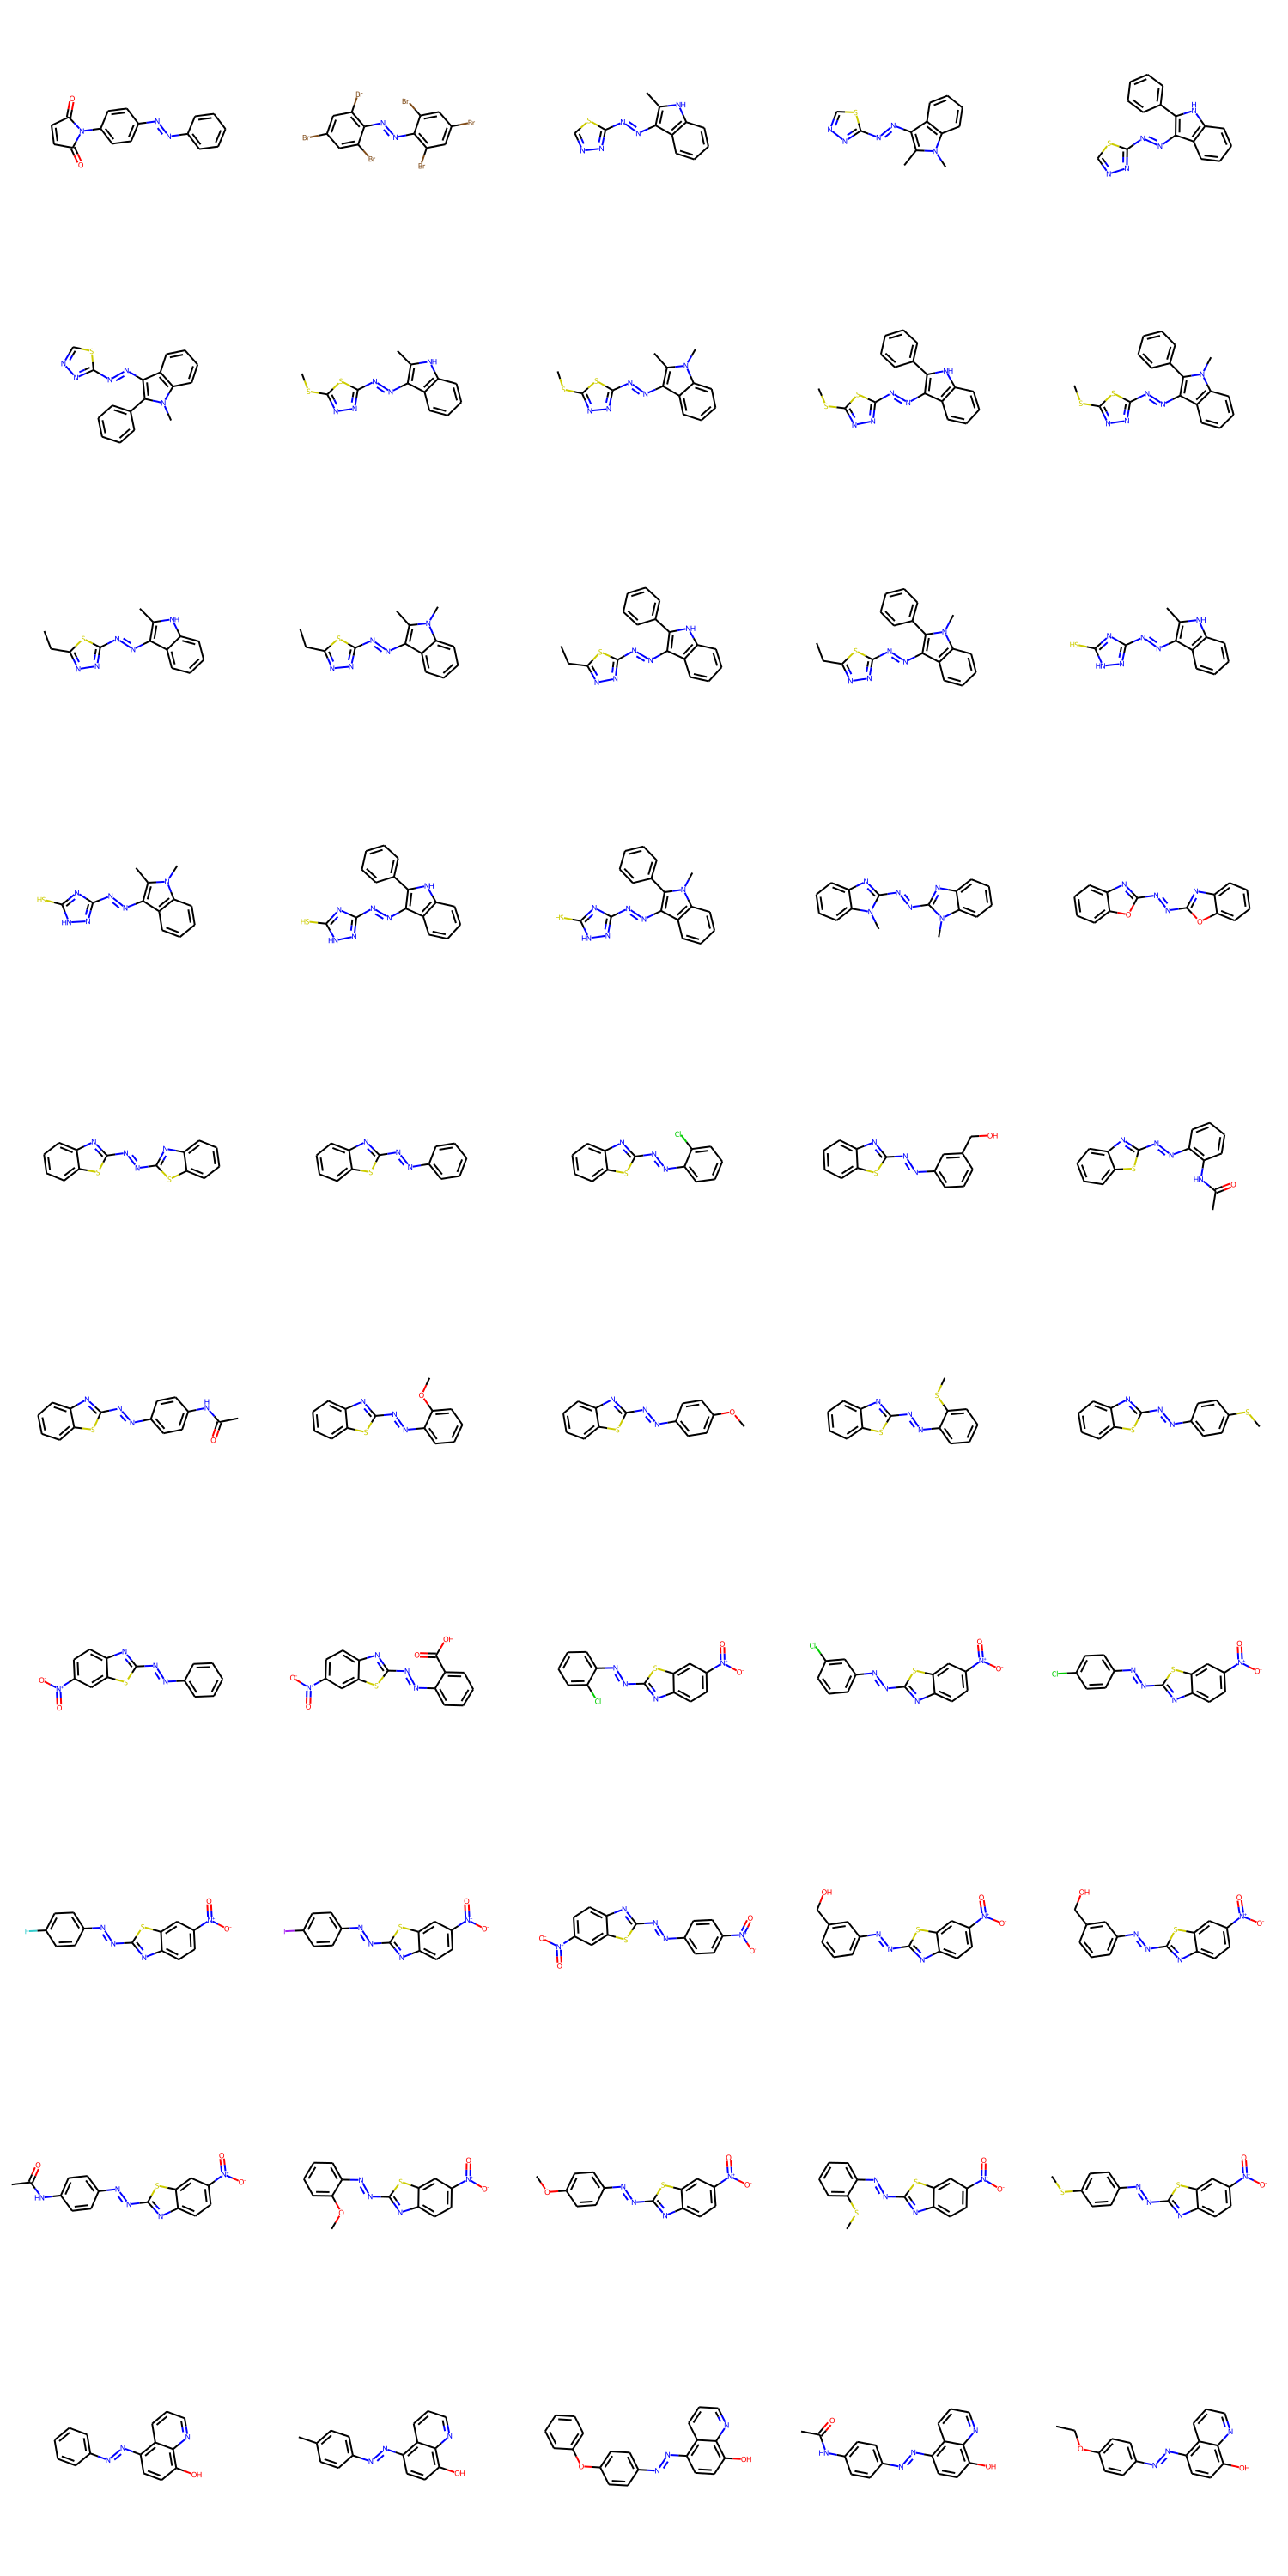

In [69]:
mols = [Chem.MolFromSmiles(x) for x in smiles[mk_3]] # draw molecules from our mk_3 cluster
Draw.MolsToGridImage(mols,molsPerRow=5,subImgSize=(300, 300))

In [ ]:
cd ~/Desktop/final_project_datacd ~/Desktop/final_project_data

In [ ]:
# finally, generate images of molecules
from rdkit.Chem import Draw
for i,mol in enumerate(rdkit_mols):
    Draw.MolToFile(mol, filename =  str(i) + ".png")


In [ ]:
Draw.MolToFile(mol, filename = "0.png")Draw.MolToFile(mol, filename = "0.png")

In [ ]:
photoswitchesphotoswitches

Since fingerprints have no real-life equivalents as opposed to descriptors. In other words, they are just unlabelled data, and so we can start off by implementing some unsupervised learning algorithms.

In [70]:
# Dimensionality reduction
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"


In [71]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Part 2 Prediction

In [ ]:
smiles_photoswitches = photoswitches["SMILES"].valuessmiles_photoswitches = photoswitches["SMILES"].values

In [158]:
photoswitches_ec = photoswitches[photoswitches['Extinction coefficient in M-1 cm-1'].notnull()]
photoswitches_ec

SMILES  ...  BHLYP/6-31G* DFT Z isomer n-pi* wavelength in nm
0                        C[N]1N=NC(=N1)N=NC2=CC=CC=C2  ...                                               NaN
1                        C[N]1C=NC(=N1)N=NC2=CC=CC=C2  ...                                               NaN
2                        C[N]1C=CC(=N1)N=NC2=CC=CC=C2  ...                                               NaN
3                     C[N]1C=C(C)C(=N1)N=NC2=CC=CC=C2  ...                                               NaN
4                        C[N]1C=C(C=N1)N=NC2=CC=CC=C2  ...                                               NaN
5                    C[N]1N=C(C)C(=C1C)N=NC2=CC=CC=C2  ...                                               NaN
6                          C[N]1N=CC=C1N=NC2=CC=CC=C2  ...                                               NaN
7                       C[N]1N=CC(=C1N=NC2=CC=CC=C2)C  ...                                               NaN
12                       CN1C(/N=N/C2=CC=CC=C2)=NC=C1  ...                                               NaN
30                    FC1=CC=CC=C1/N=N/C2=C(F)C=CC=C2  ...                                               NaN
31                    FC1=CC=CC(F)=C1/N=N/C2=CC=CC=C2  ...                                               NaN
32                FC1=CC=CC(F)=C1/N=N/C2=C(F)C=CC=C2F  ...                                               NaN
33        FC1=CC(F)=CC(F)=C1/N=N/C(C(F)=C2)=C(F)C=C2F  ...                                               NaN
34    FC1=C(F)C=C(F)C(F)=C1/N=N/C2=C(F)C(F)=CC(F)=C2F  ...                                               NaN
35  FC1=C(F)C(F)=C(F)C(F)=C1/N=N/C2=C(F)C(F)=C(F)C...  ...                                               NaN
36          FC1=CC=CC(F)=C1/N=N/C2=CC=C(C(OCC)=O)C=C2  ...                                               NaN
37  FC1=CC(C(OCC)=O)=CC(F)=C1/N=N/C2=C(F)C=C(C(OCC...  ...                                               NaN
38      FC1=CC(C(OCC)=O)=CC(F)=C1/N=N/C2=C(F)C=CC=C2F  ...                                               NaN
39  FC1=CC(C(OCC)=O)=CC(F)=C1/N=N/C2=CC=C(C(OCC)=O...  ...                                               NaN
40          FC1=CC(C(OCC)=O)=CC(F)=C1/N=N/C2=CC=CC=C2  ...                                               NaN
53  CC(NC(C=C1)=CC(OC)=C1/N=N/C2=C(OC)C=C(NC(C)=O)...  ...                                               NaN
55                    COC(C=CN=C1)=C1/N=N/C2=CC=CC=C2  ...                                               NaN
56                      C1(/N=N/C2=CC=CC=C2)=CC=CN=C1  ...                                               NaN
57                     CC1=C(/N=N/C2=CC=CC=C2)C=NC=C1  ...                                               NaN
58                 CC(C)C1=C(/N=N/C2=CC=CC=C2)C=NC=C1  ...                                               NaN
60                 CN(C)C1=C(/N=N/C2=CC=CC=C2)C=NC=C1  ...                                               NaN

[26 rows x 33 columns]

In [159]:
photoswitches_ec = photoswitches[photoswitches['Extinction coefficient in M-1 cm-1'].notnull()]
#photoswitches_ec

In [160]:
smiles_photoswitches_for_ec_cal = photoswitches_ec["SMILES"]
extinction_coefficient_photoswitches_for_ec_cal  = photoswitches_ec["Extinction coefficient in M-1 cm-1"]

In [161]:
len(extinction_coefficient_photoswitches_for_ec_cal)

26

In [79]:
# Now, it's time to split our data set into training & test group
Train, Test, TrainTargets , TestTargets = train_test_split(smiles_photoswitches_for_ec_cal , extinction_coefficient_photoswitches_for_ec_cal, test_size=0.25,random_state=42) #Yeah the magical 42
print("We have", len(Test), "molecules in the test set, out of a total of", len(smiles_photoswitches_for_ec_cal ))



We have 7 molecules in the test set, out of a total of 26


In [162]:
# Convert a single SMILES to RDKIT molecule format
def SMILES2MOL(mole):
    return Chem.MolFromSmiles(mole)
# Convert an array/vector of SMILES data to RDKIT mole format
def SMILES2MOLES(moles):
    vectSMILES2MOL=np.vectorize(SMILES2MOL)
    return vectSMILES2MOL(moles)

In [163]:
# Convert into a different format (rdkit internal)
PTR= SMILES2MOLES(Train)
PTE= SMILES2MOLES(Test)

In [164]:
#V1 -- RDKIT
# Based on our precious calculation on the relative importance of the RDKIT descriptors, we came up with this
#
# Choosing the descriptors for training (ECTR) and test (ECTE) sets of extinction coefficients. 
from rdkit.Chem import Descriptors

ECTR=[]
for m in PTR:
    desc=[]
    desc.append(Descriptors.MaxEStateIndex (m)) 
    desc.append(Descriptors.MinEStateIndex (m)) 
    desc.append(Descriptors.MaxAbsEStateIndex (m))
    desc.append(Descriptors.MinAbsEStateIndex (m))
    desc.append(Descriptors.qed(m))
    desc.append(Descriptors.MolWt (m))
    desc.append(Descriptors.HeavyAtomMolWt(m))

    ECTR.append(desc)

    
ECTE=[]
for m in PTE:
    desc=[]
    desc.append(Descriptors.MaxEStateIndex (m)) 
    desc.append(Descriptors.MinEStateIndex (m)) 
    desc.append(Descriptors.MaxAbsEStateIndex (m))
    desc.append(Descriptors.MinAbsEStateIndex (m))
    desc.append(Descriptors.qed(m))
    desc.append(Descriptors.MolWt (m))
    desc.append(Descriptors.HeavyAtomMolWt(m))
    
    ECTE.append(desc)

In [165]:
# 
from sklearn.gaussian_process import GaussianProcessRegressor 
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process.kernels import Matern, WhiteKernel
kernel=RBF(length_scale_bounds=(5e-02,10)) 

gp=GaussianProcessRegressor(kernel=kernel,normalize_y=True,n_restarts_optimizer=10,alpha=1e-4);

# Fit our GP model
gp.fit(ECTR,TrainTargets);

In [166]:
# Use the trained GP to predict the solubility of our training set...
TrainPred=gp.predict(ECTR).reshape(-1,1)
# ... and of our test set
TestPred=gp.predict(ECTE).reshape(-1,1)

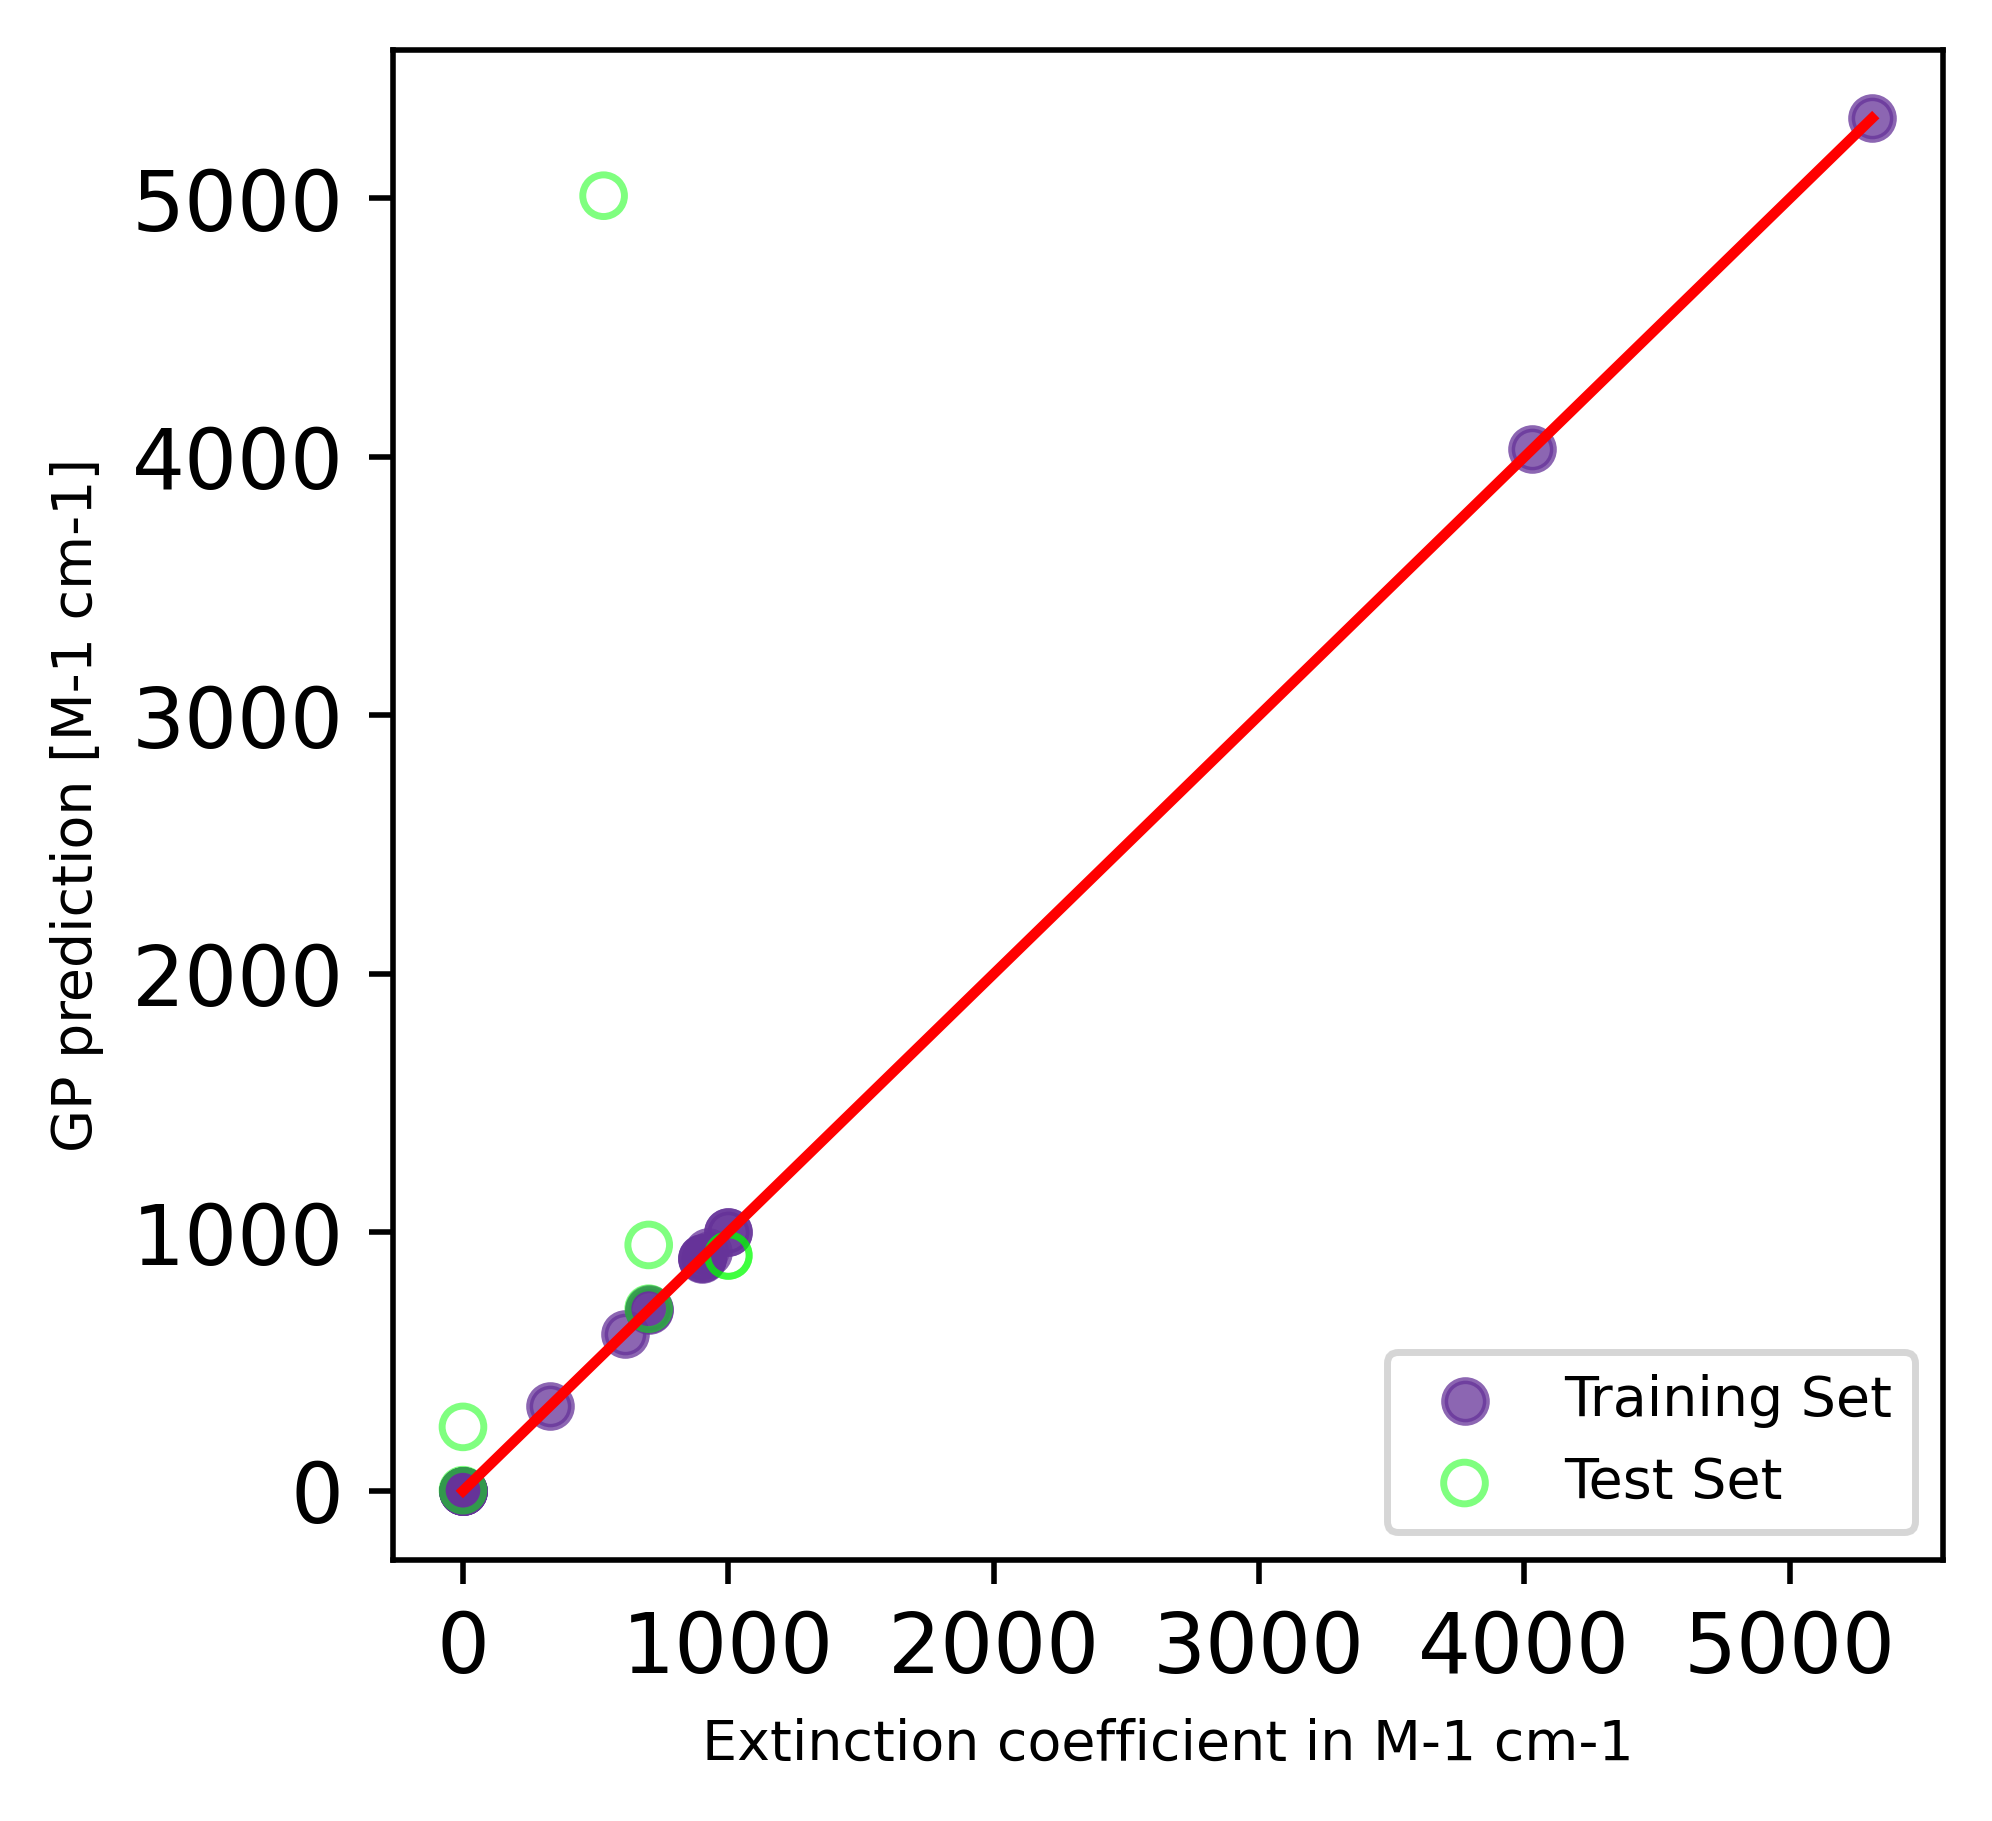

In [167]:
# Let's have a look!
fig=plt.figure(num=None,figsize=(4,4),dpi=500,facecolor='w',edgecolor='k')
plt.xlabel('Extinction coefficient in M-1 cm-1',fontsize=8)
plt.ylabel('GP prediction [M-1 cm-1]',fontsize=8)
x = np.linspace(min(TrainTargets), max(TrainTargets), 1000)
plt.plot(x, x + 0, '-r')
plt.scatter(TrainTargets,TrainPred,color='rebeccapurple',alpha=0.75,label='Training Set')
plt.scatter(TestTargets,TestPred,color='lime',alpha=0.5,label='Test Set',facecolors='none')
plt.legend(fontsize=8,loc=4);



In [168]:
#V2 -- MORDERED
# Based on our precious calculation on the relative importance of the MORDERED descriptors, we came up with this
#
# Choosing the descriptors for training (ECTR) and test (ECTE) sets of extinction coefficients. 



ECTR=[]
for m in PTR:
    desc=[]
    desc.append(descriptors.ABCIndex(m)) 
    desc.append(descriptors.ABCGG  (m)) 
    desc.append(descriptors.nAcid  (m))
    desc.append(descriptors.nBase (m))
    desc.append(descriptors.SpAbs_A (m))
    desc.append(descriptors.SpMax_A (m))
    desc.append(Descriptors.SpDiam_A(m))

    ECTR.append(desc)

    
ECTE=[]
for m in PTE:
    desc=[]
    desc.append(descriptors.ABCIndex   (m)) 
    desc.append(descriptors.ABCGG  (m)) 
    desc.append(descriptors.nAcid  (m))
    desc.append(descriptors.nBase (m))
    desc.append(descriptors.SpAbs_A (m))
    desc.append(descriptors.SpMax_A (m))
    desc.append(Descriptors.SpDiam_A(m))
    
    ECTE.append(desc)

TypeError: ignored